In [1]:
targetFolderHBK = r"H:\Extracted_Features\HBK\HBK_14285Hz_original_all_features\features"
targetFolderMCC5 = r"H:\Extracted_Features\MCC5\MCC5_12800Hz_original_all_features_motor_vibration_x\features"
targetFolderSIZA = r"H:\Extracted_Features\SIZA\SIZA_original_all_features\features"
normalization_method = "z_score"

In [2]:
experiment_name = "original_data_analysis_binary"
project_name="original_data_analysis_binary",
run_name="original_data_analysis_binary"
domain="all"

In [3]:
binary_classification=True
plot_histograms_choice=False
include_augmentations=True

# Environment Setup & Imports

In [4]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import numpy as np
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, jaccard_score, log_loss, precision_score, recall_score, f1_score, make_scorer
from pathlib import Path
from pycaret.classification import * 
from torch import tensor
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
import optuna
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, CategoryEmbeddingModel,GatedAdditiveTreeEnsembleConfig, NodeConfig, FTTransformerConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    ModelConfig,
    TrainerConfig,
    ExperimentConfig,
)
from collections import Counter
from data_loader import load_feature_data

## Helper Functions

In [5]:
def plotHistograms(dataframe, normalization):
    for col in dataframe.columns:
        if col == "Label":
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(data = dataframe, x=col, hue='Label', kde=True, multiple='layer', element='step', alpha=0.5)
        plt.title(f"Distribution of {col} with {normalization}")
        plt.show()

In [6]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

In [7]:
def plotPredictionHistograms(df, normalization):
    # 1) mark correct vs incorrect
    df = df.copy()
    df['prediction_quality'] = np.where(
        df['Label'] == df['prediction_label'],
        'correct',
        'incorrect'
    )
    
    # 2) choose a palette (you can override these colors if you like)
    pal = dict(zip(
        ['correct','incorrect'],
        sns.color_palette(n_colors=2)
    ))
    
    skip = {'Label','prediction_label','prediction_score','prediction_quality'}
    for col in df.columns:
        if col in skip:
            continue
        
        fig, ax = plt.subplots(figsize=(8,4))
        sns.histplot(
            data=df, x=col, hue='prediction_quality',
            palette=pal,
            kde=True, multiple='layer', element='step',
            alpha=0.5,
            ax=ax
        )
        
        # 3) build a manual legend using the same palette
        handles = [
            mpatches.Patch(color=pal[k], label=k)
            for k in ['correct','incorrect']
        ]
        ax.legend(
            handles=handles,
            title='Prediction Quality'
        )
        
        ax.set_title(
            f"Distribution of {col}\n"
            f"(normalization = '{normalization}')"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

In [8]:
def get_incorrect_predictions(df):
    return df[
        ((df['Label'] == 'damaged')   & (df['prediction_label'] == 'healthy'))
      | ((df['Label'] == 'healthy')  & (df['prediction_label'] == 'damaged'))
    ].copy()

In [9]:
def get_feature_importance_df(model, df):
    importance = model.feature_importances_
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': importance
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [10]:
def get_svm_feature_importance_df(model, df):
    if not hasattr(model, 'coef_'):
        raise ValueError("This SVM model has no coefficients. Use a linear kernel.")
    
    importance = model.coef_.ravel()  # Flatten in case of binary classification
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': abs(importance)
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


In [11]:
feature_counter = Counter()
def add_top_features(feature_df: pd.DataFrame, top_n: int):
    top_features = feature_df.nlargest(top_n, 'importance')['Features']
    feature_counter.update(top_features)
    
def plot_feature_importance():
    feature_freq = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_freq.sort_values(by='Count', ascending=False),
                x='Feature', y='Count')
    plt.xticks(rotation=45)
    plt.title('Feature Frequency Across Experiments')
    plt.tight_layout()
    plt.show()

In [12]:
def save_feature_counter(exp_name: str, folder: str = f"top_features_{experiment_name}"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{exp_name}_features.csv")
    df = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    df.to_csv(filepath, index=False)

## Import Dataset

In [13]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
)

Successfully loaded 966 files into a DataFrame with shape (1140403, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (1140403, 28)


In [14]:
df_SIZA = load_feature_data(
    features_path=targetFolderSIZA,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
)

Successfully loaded 216 files into a DataFrame with shape (307368, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (307368, 28)


In [15]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
)

Successfully loaded 216 files into a DataFrame with shape (307368, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (307368, 28)


In [16]:
combined_df = pd.concat([df_HBK, df_SIZA, df_MCC5], ignore_index=True)

In [17]:
normalized_df = normalizeDataframe(combined_df, normalization_method)

In [18]:
features_df_training_normalized, features_df_testing_normalized = train_test_split(
    normalized_df, 
    test_size=0.2,    # e.g., 20% for testing
    random_state=42   # for reproducibility
)

# Histograms

## Histograms Training and Testing [NO-Normalization]

In [19]:
if (plot_histograms_choice):
    plotHistograms(combined_df, normalization_method)

## Histograms Training and Testing [Z-Score Normalization]

In [20]:
if (plot_histograms_choice):
    plotHistograms(normalized_df, normalization_method)

# Experiment Setup (ML)

## Setup Hyperparameters

In [21]:
experiment = setup(features_df_training_normalized, target='Label', log_experiment = True, experiment_name = experiment_name, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

,Description,Value
0,Session id,8449
1,Target,Label
2,Target type,Binary
3,Target mapping,"damaged: 0, healthy: 1"
4,Original data shape,"(1404111, 28)"
5,Transformed data shape,"(1404111, 28)"
6,Transformed train set shape,"(982877, 28)"
7,Transformed test set shape,"(421234, 28)"
8,Numeric features,27
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

## Add aditional metrics

In [22]:
# Binary classification metrics
add_metric('balanced_acc', 'Balance Acc', balanced_accuracy_score, target='pred', greater_is_better=True)
add_metric('hamming_loss', 'Hamming Loss', hamming_loss, target='pred', greater_is_better=False)
add_metric('jaccard_score', 'Jaccard Score', jaccard_score, target='pred', greater_is_better=True)
add_metric('log_loss', 'Log Loss', log_loss, target='pred_proba', greater_is_better=False)

Name                                                          Log Loss
Display Name                                                  Log Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: log_loss, dtype: object

In [23]:
all_metrics = get_metrics()
all_metrics

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x0000029728A5F2E0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x0000029728A5F...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x0000029728A5F...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
balanced_acc,Balance Acc,Balance Acc,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True
hamming_loss,Hamming Loss,Hamming Loss,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(hamming_loss, greater_is_better=Fa...",pred,{},False,True,True


## Light Gradient Boosting Machine

In [24]:
bestParamsLIGHTGBM = {
    'bagging_fraction': 0.8455104741417432,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'device': 'gpu',
    'feature_fraction': 0.42947671039481,
    'importance_type': 'split',
    'learning_rate': 0.47910287588557177,
    'max_depth': -1,
    'min_child_samples': 41,
    'min_child_weight': 0.001,
    'min_split_gain': 0.23016472358397666,
    'n_estimators': 245,
    'n_jobs': -1,
    'num_leaves': 250,
    'objective': None,
    'random_state': 1768,
    'reg_alpha': 0.00039695268896179983,
    'reg_lambda': 3.6071600095045767e-06,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


In [25]:
lightgbm = create_model('lightgbm', **bestParamsLIGHTGBM)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
Fold,,,,,,,,,,,
0,0.8682,0.8877,0.8682,0.8845,0.8732,0.6540,0.6616,0.8566,0.1318,0.5884,3.6768
1,0.8181,0.5844,0.8181,0.8077,0.7852,0.3338,0.3873,0.6305,0.1819,0.2637,5.4939
2,0.8164,0.8163,0.8164,0.8478,0.8258,0.5372,0.5505,0.8052,0.1836,0.4907,5.6477
3,0.9051,0.8464,0.9051,0.9025,0.9018,0.7108,0.7157,0.8340,0.0949,0.6259,2.4648
4,0.8416,0.8658,0.8416,0.8696,0.8495,0.5988,0.6125,0.8384,0.1584,0.5424,4.6260
5,0.8796,0.8514,0.8796,0.8797,0.8796,0.6556,0.6556,0.8282,0.1204,0.5790,3.2315
6,0.9174,0.9057,0.9174,0.9159,0.9164,0.7578,0.7585,0.8701,0.0826,0.6814,1.8567
7,0.8955,0.8864,0.8955,0.8979,0.8965,0.7066,0.7071,0.8604,0.1045,0.6321,2.7516
8,0.8682,0.8319,0.8682,0.8696,0.8688,0.6263,0.6265,0.8164,0.1318,0.5525,3.7153


Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


2025/10/06 16:23:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [26]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [27]:
lightgbm_top_features = get_feature_importance_df(lightgbm, features_df_training_normalized)
lightgbm_top_features

,Features,importance
0,mean,3684
1,spectral_skewness,3508
2,skewness,3410
3,bandwidth,3369
4,kurtosis,3202
5,medianFreq,3167
6,meanFreq,3165
7,shape,3054
8,spectral_flatness,2965
9,crest,2848


In [28]:
add_top_features(lightgbm_top_features, top_n=3)

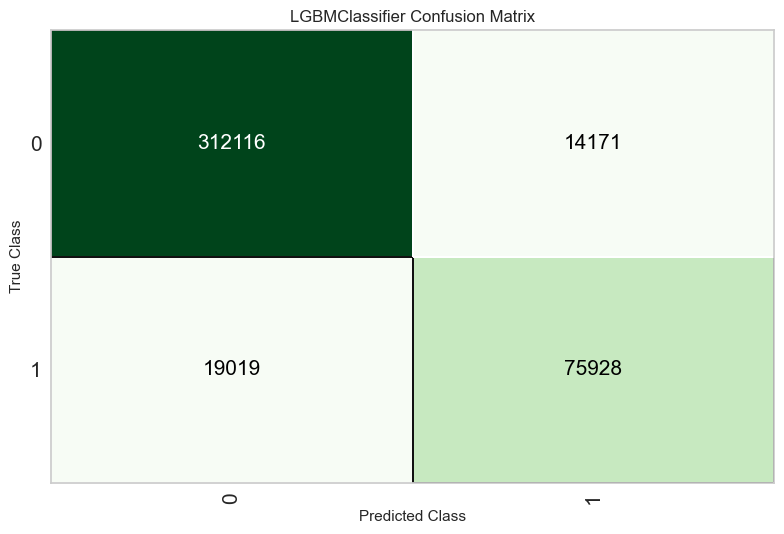

In [72]:
plot_model(lightgbm, plot='confusion_matrix')

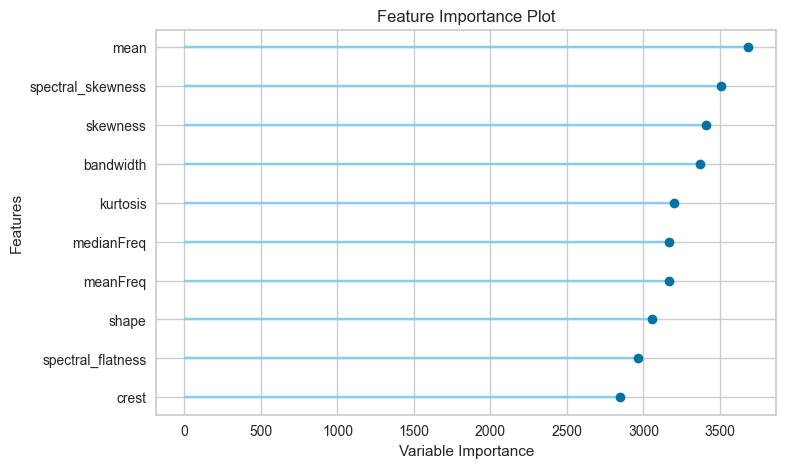

In [29]:
plot_model(lightgbm, plot='feature')

In [30]:
predictions_lightgbm = predict_model(lightgbm, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Light Gradient Boosting Machine,0.9213,0.9124,0.9213,0.9202,0.9206,0.7701,0.7706,0.8777,0.0787,0.6955,1.7645


[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [31]:
predictions_lightgbm

,mean,rms,std,skewness,kurtosis,ptp,crest,impulse,clearance,shape,...,varWavelet,entropyWavelet,energyWavelet,meanSpectrogram,varSpectrogram,entropySpectrogram,energySpectrogram,Label,prediction_label,prediction_score
1575777,0.038350,-0.273183,-0.276917,-0.081938,0.072762,-0.242743,0.359123,0.472435,0.202777,1.289967,...,-0.238003,0.176429,-0.260476,-0.212684,-0.109719,-0.145942,-0.109887,damaged,damaged,0.9609
269280,0.056265,-0.457678,-0.477689,0.001200,-0.149608,-0.613921,-0.297836,-0.299343,-0.655130,-0.331626,...,-0.263216,0.160634,-0.289041,-0.229663,-0.109744,-0.146138,-0.109912,healthy,healthy,1.0000
891733,-0.044086,-0.497980,-0.529957,-0.108341,-0.107325,-0.672246,0.002615,-0.073609,-0.705494,-0.249693,...,-0.269985,0.157745,-0.294056,-0.231473,-0.109745,-0.146150,-0.109913,damaged,damaged,1.0000
210511,0.061453,-0.511436,-0.536242,-0.091563,-0.131220,-0.702077,-0.772699,-0.609694,-0.903097,-0.159876,...,-0.268224,0.156943,-0.293740,-0.232124,-0.109745,-0.146150,-0.109913,damaged,damaged,1.0000
845522,0.089384,0.102069,0.131564,-0.231113,0.084522,0.671010,1.464663,0.968683,1.225292,-0.217150,...,-0.135619,0.202841,-0.138523,-0.143775,-0.109585,-0.144796,-0.109733,damaged,damaged,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121923,0.065295,-0.552289,-0.580818,0.254874,-0.121871,-0.752811,-0.591739,-0.365515,-0.954459,0.624643,...,-0.270479,0.154243,-0.296015,-0.233208,-0.109746,-0.146153,-0.109913,damaged,damaged,1.0000
1427683,0.033469,0.299339,0.346429,0.399551,-0.121596,0.455634,-0.168177,-0.213924,0.607999,-0.366616,...,-0.021847,0.177855,-0.025567,-0.073922,-0.108182,-0.136921,-0.108317,damaged,damaged,1.0000
554972,0.070844,-0.561135,-0.590694,0.874219,0.018663,-0.757028,0.106472,0.108895,-0.924448,0.358673,...,-0.270640,0.153603,-0.296339,-0.233478,-0.109746,-0.146153,-0.109913,healthy,healthy,1.0000
673674,0.061933,-0.009165,0.010606,-0.550994,0.057409,0.132810,0.068274,0.040057,0.368232,0.129063,...,-0.167029,0.200031,-0.180402,-0.170853,-0.109651,-0.145353,-0.109810,damaged,damaged,1.0000


In [32]:
get_incorrect_predictions(predictions_lightgbm)

,mean,rms,std,skewness,kurtosis,ptp,crest,impulse,clearance,shape,...,varWavelet,entropyWavelet,energyWavelet,meanSpectrogram,varSpectrogram,entropySpectrogram,energySpectrogram,Label,prediction_label,prediction_score
1347639,0.039352,-0.303285,-0.309686,0.155798,-0.060305,-0.338154,-0.063727,-0.095649,-0.217679,-0.104413,...,-0.243124,0.178550,-0.265275,-0.215459,-0.109735,-0.146056,-0.109903,damaged,healthy,0.5162
1742974,0.017107,-0.160396,-0.154358,0.420189,-0.079311,-0.120955,0.255936,0.103084,0.168135,-0.263326,...,-0.227108,0.187499,-0.244171,-0.194604,-0.109703,-0.145788,-0.109868,damaged,healthy,1.0000
225015,0.063351,-0.409407,-0.425160,0.628118,-0.211431,-0.605704,-0.904592,-0.781770,-0.722801,-0.749246,...,-0.259220,0.167420,-0.283306,-0.226765,-0.109743,-0.146130,-0.109911,damaged,healthy,1.0000
63608,0.071190,-0.605642,-0.640658,1.179026,-0.019593,-0.820256,0.309875,0.448247,-1.190056,1.364971,...,-0.271493,0.151822,-0.297312,-0.233946,-0.109746,-0.146153,-0.109913,healthy,damaged,1.0000
48592,0.067535,-0.582086,-0.613486,-0.432207,-0.049784,-0.783120,-0.043709,-0.086205,-1.074424,-0.132581,...,-0.271180,0.152578,-0.296957,-0.233741,-0.109746,-0.146153,-0.109913,healthy,damaged,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556125,0.106863,-0.564023,-0.598284,1.728142,0.149849,-0.755916,1.424856,1.141760,-0.740422,0.622162,...,-0.271186,0.153241,-0.296685,-0.233448,-0.109746,-0.146153,-0.109913,healthy,damaged,1.0000
64378,0.063278,-0.606164,-0.639767,0.388795,-0.007163,-0.817632,0.527082,0.498909,-1.191082,0.764896,...,-0.271495,0.151816,-0.297314,-0.233951,-0.109746,-0.146153,-0.109913,healthy,damaged,1.0000
571723,0.067625,-0.606465,-0.640818,-0.213917,-0.150812,-0.821365,-0.115344,-0.215745,-1.275067,-0.596890,...,-0.271499,0.151778,-0.297326,-0.233951,-0.109746,-0.146153,-0.109913,healthy,damaged,1.0000
678970,0.068450,-0.605925,-0.640346,-0.963415,-0.099685,-0.819944,-0.265125,-0.390779,-1.285848,-1.037637,...,-0.271496,0.151768,-0.297328,-0.233950,-0.109746,-0.146153,-0.109913,healthy,damaged,1.0000


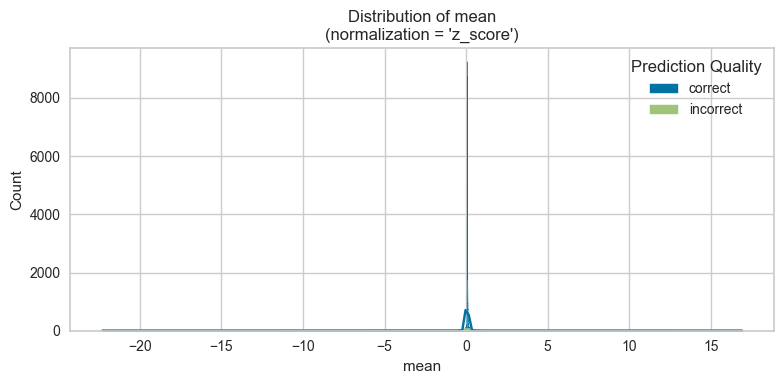

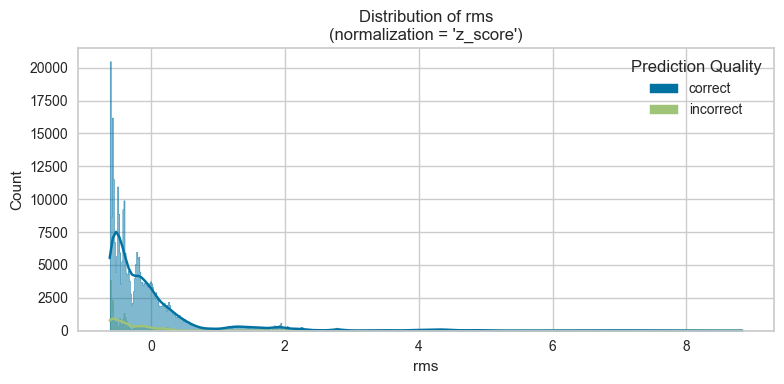

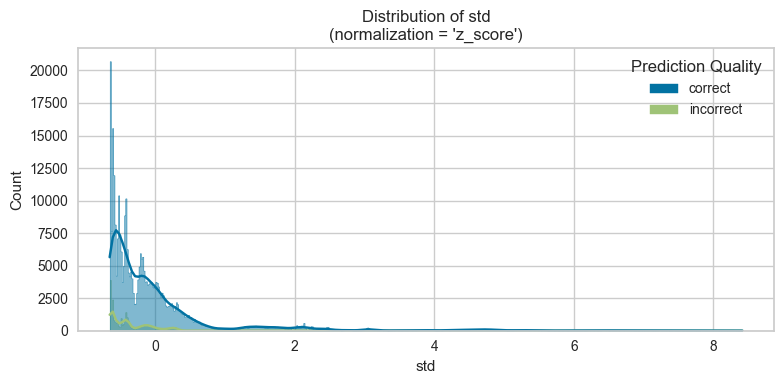

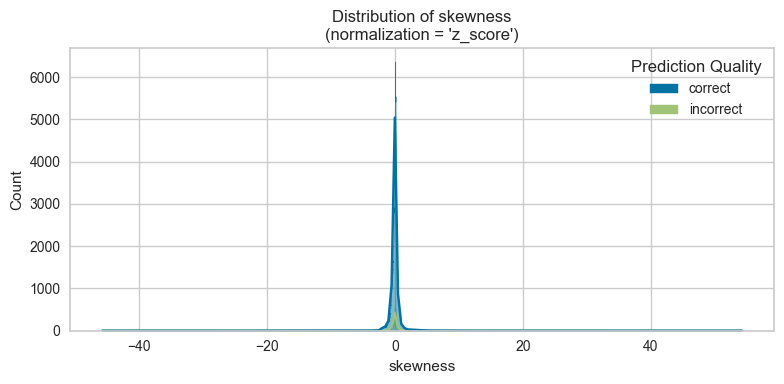

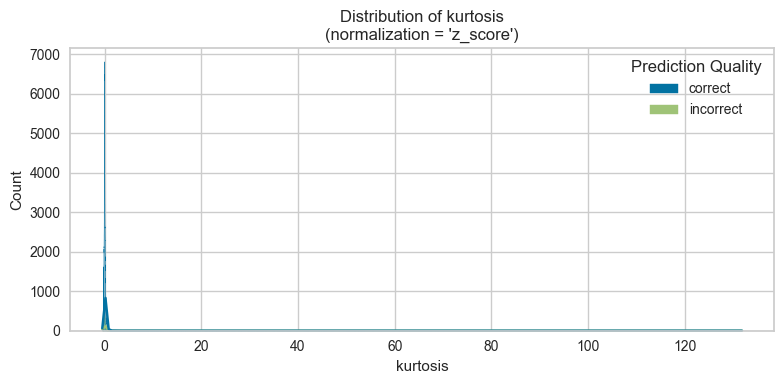

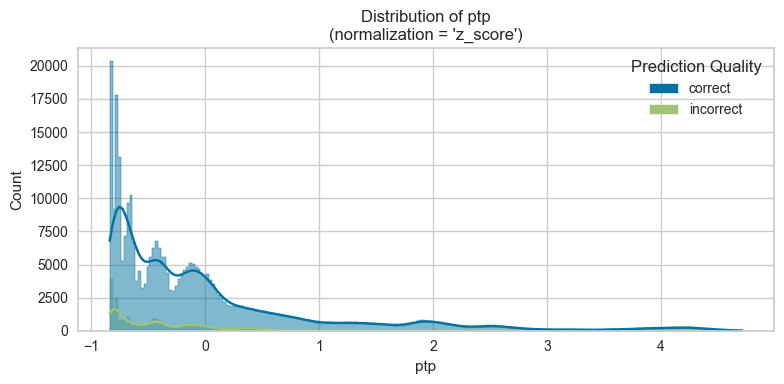

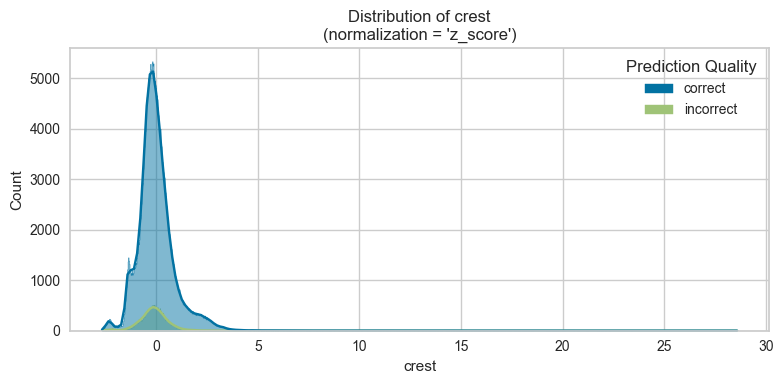

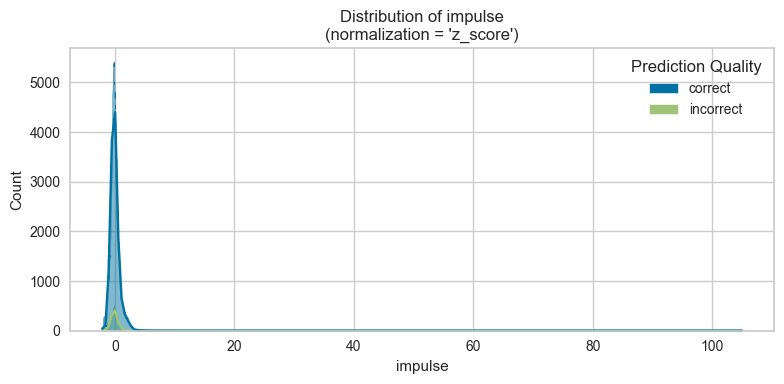

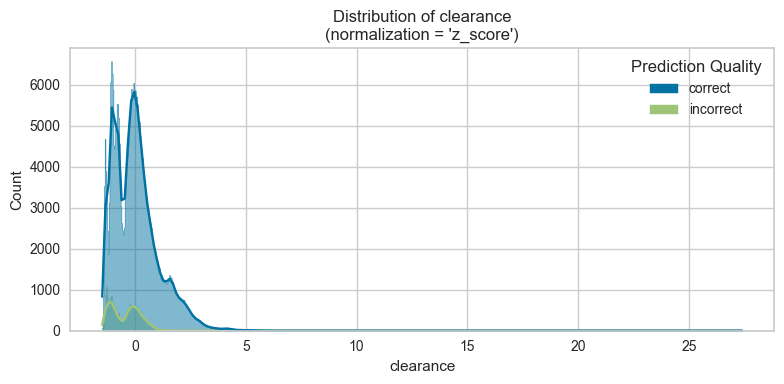

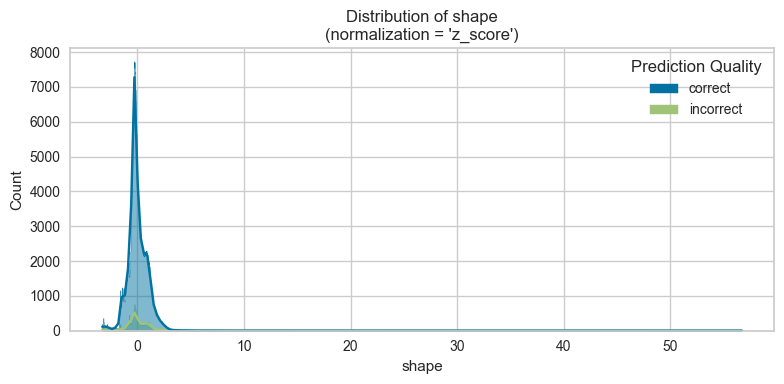

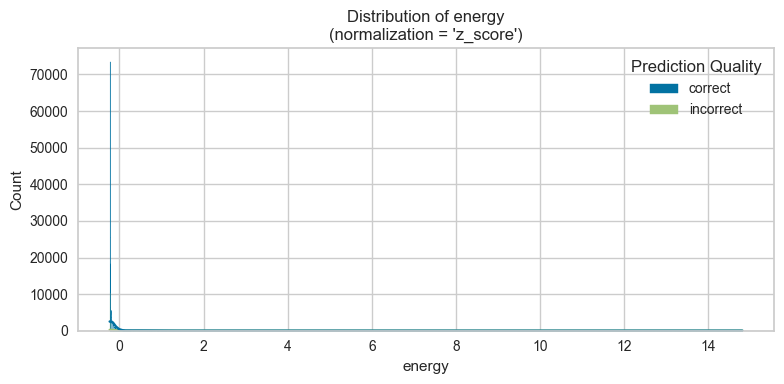

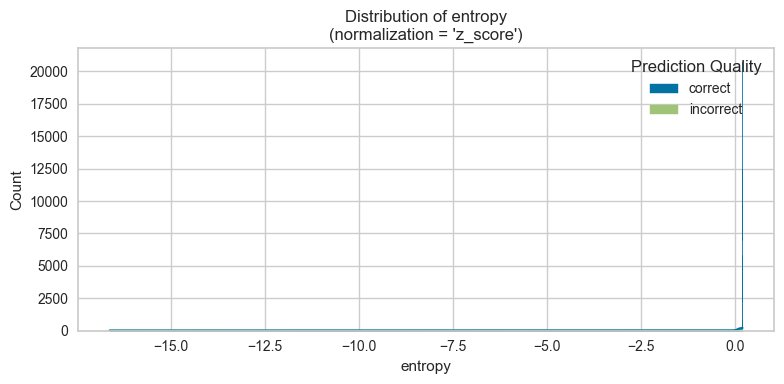

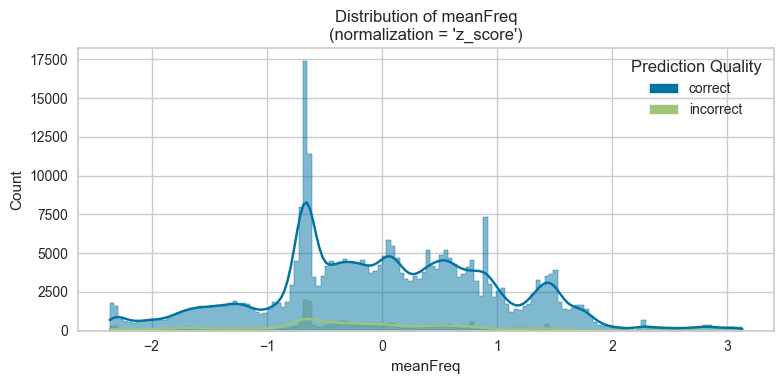

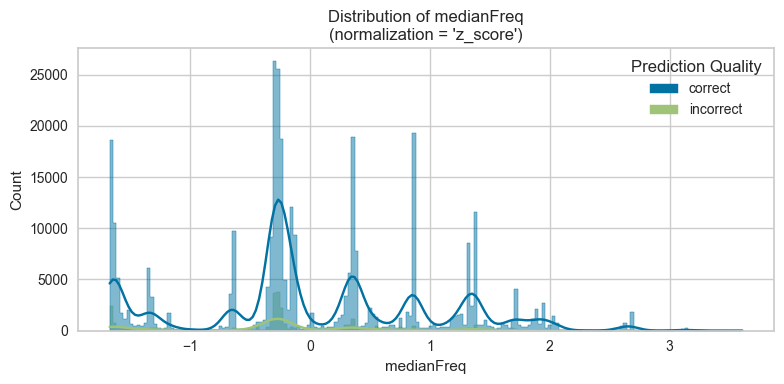

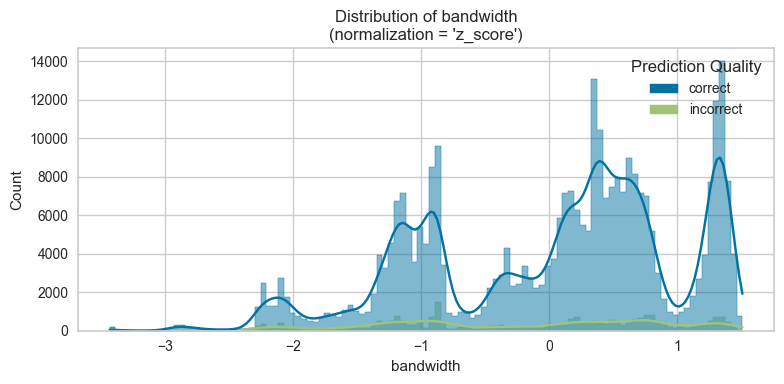

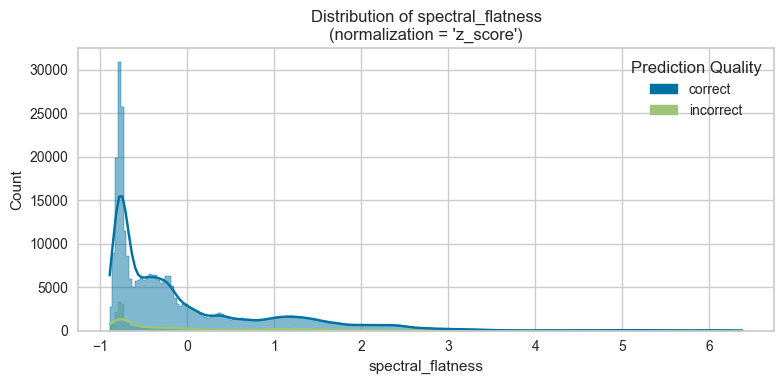

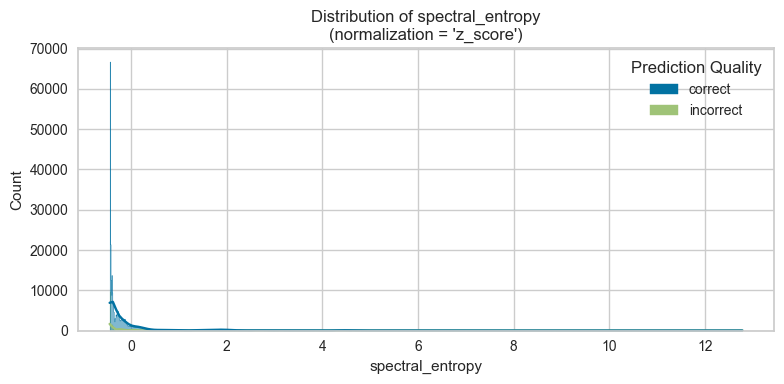

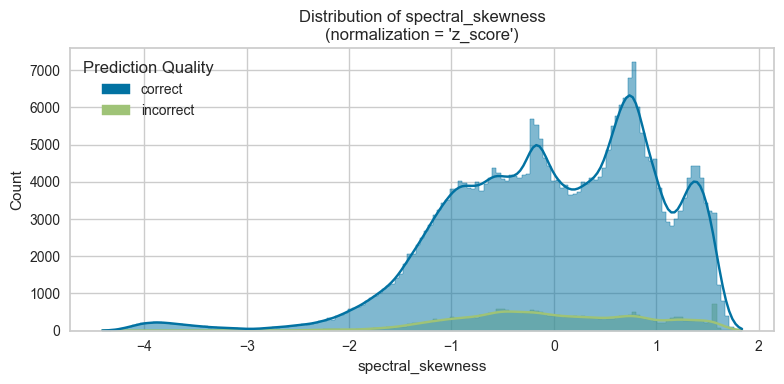

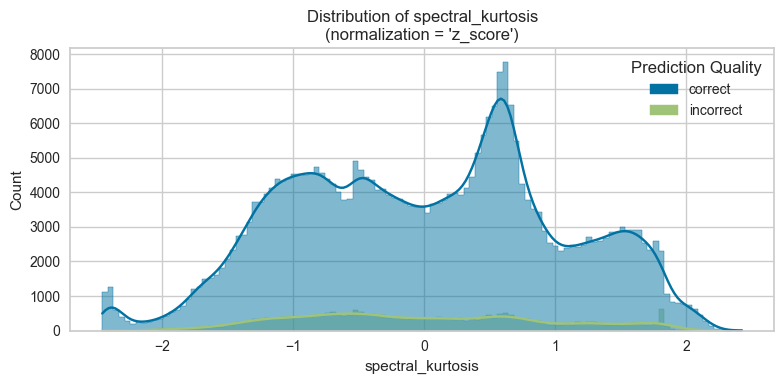

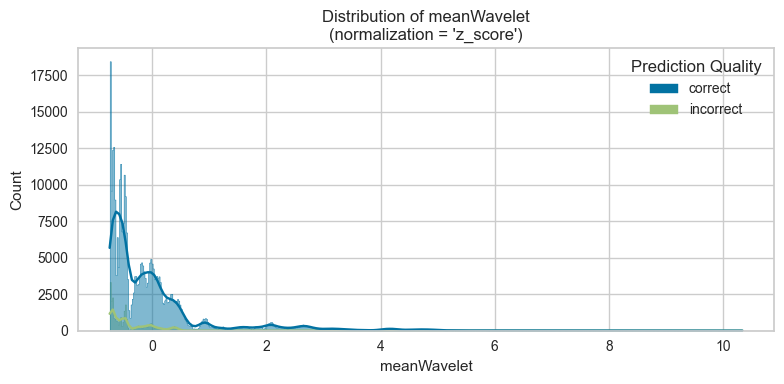

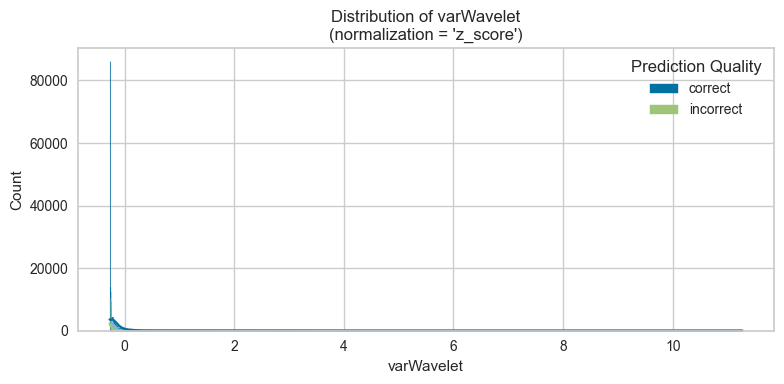

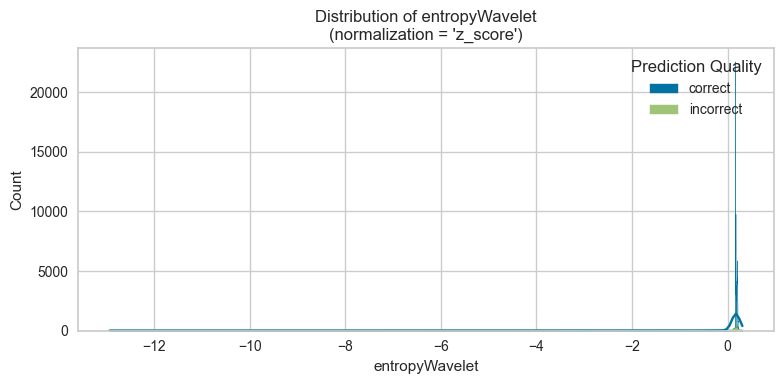

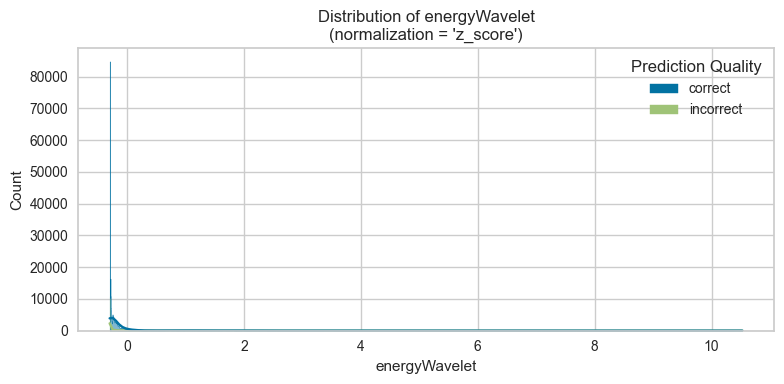

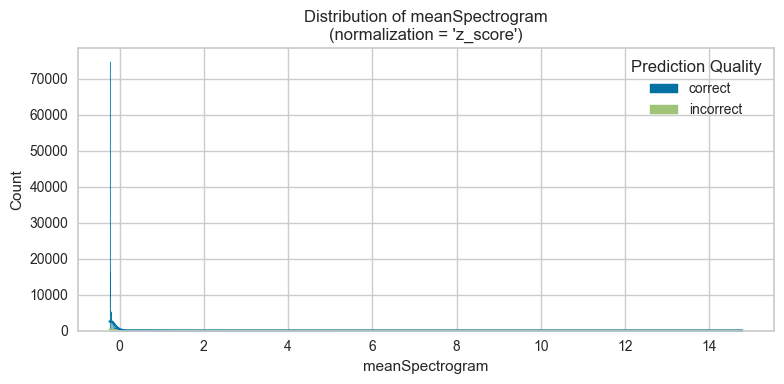

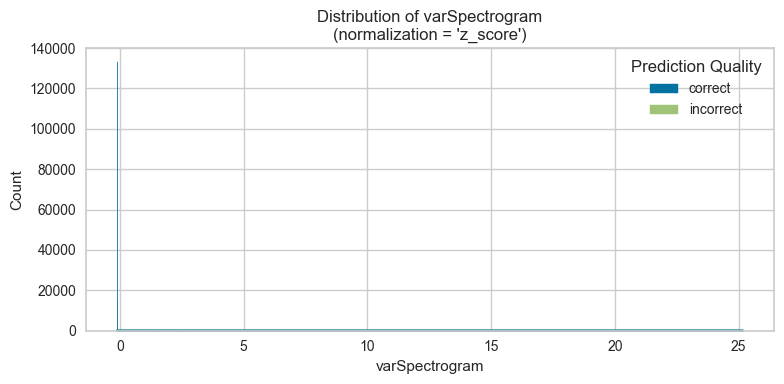

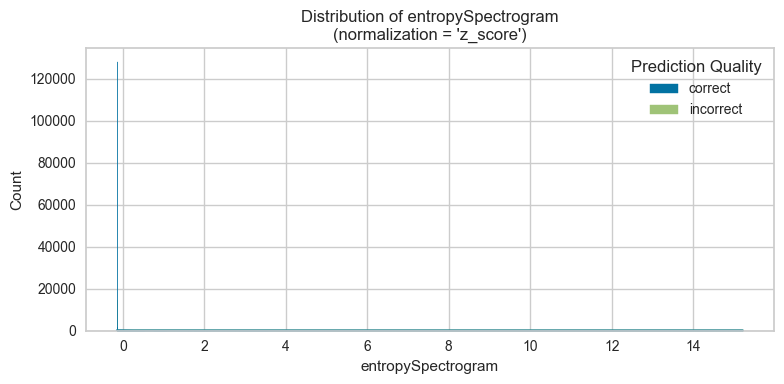

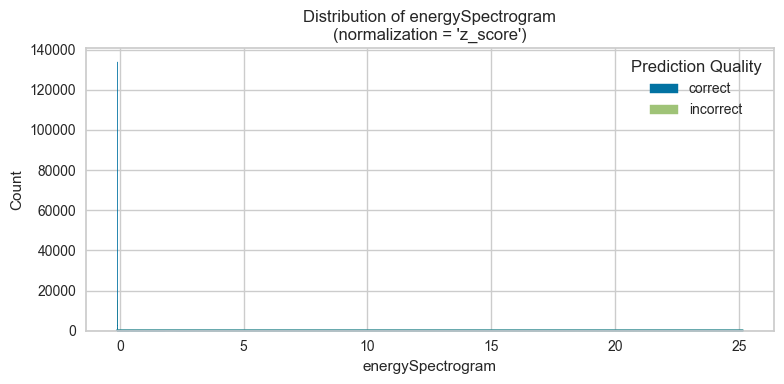

In [33]:
plotPredictionHistograms(predictions_lightgbm, normalization_method)

## Random Forest Classifier

In [34]:
bestParamsRF = {
    'bootstrap':True, 
    'ccp_alpha':0.0, 
    'class_weight':None,
    'criterion':'gini', 
    'max_depth':None, 
    'max_features':'sqrt',
    'max_leaf_nodes':None, 
    'max_samples':None,
    'min_impurity_decrease':0.0, 
    'min_samples_leaf':1,
    'min_samples_split':2, 
    'min_weight_fraction_leaf':0.0,
    'monotonic_cst':None, 
    'n_estimators':100, 
    'n_jobs':-1,
    'oob_score':False, 
    'random_state':1768, 
    'verbose':False,
    'warm_start':False
}

In [35]:
rf = create_model('rf', **bestParamsRF)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [36]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [37]:
rf_top_features = get_feature_importance_df(rf, features_df_training_normalized)
rf_top_features

,Features,importance
0,meanWavelet,0.114733
1,medianFreq,0.095638
2,spectral_entropy,0.069849
3,meanFreq,0.055585
4,std,0.053672
5,rms,0.048458
6,skewness,0.045137
7,energyWavelet,0.040205
8,ptp,0.037430
9,spectral_skewness,0.037100


In [38]:
add_top_features(rf_top_features, top_n=3)

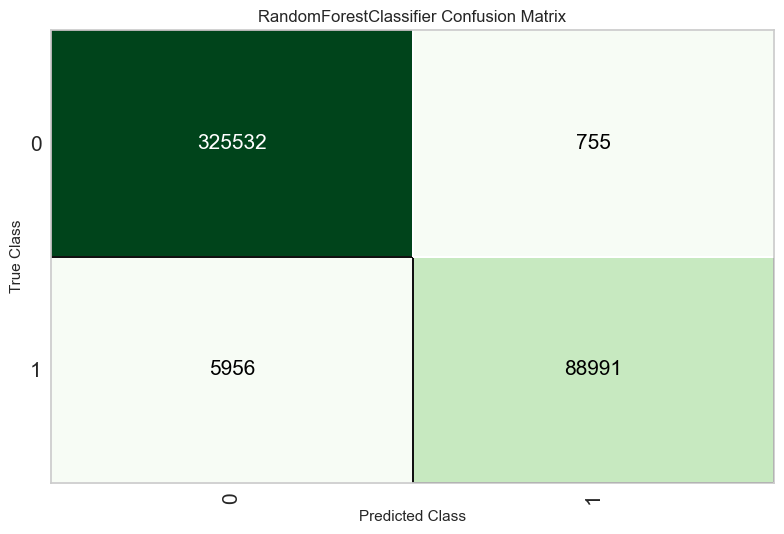

In [71]:
plot_model(rf, plot='confusion_matrix')

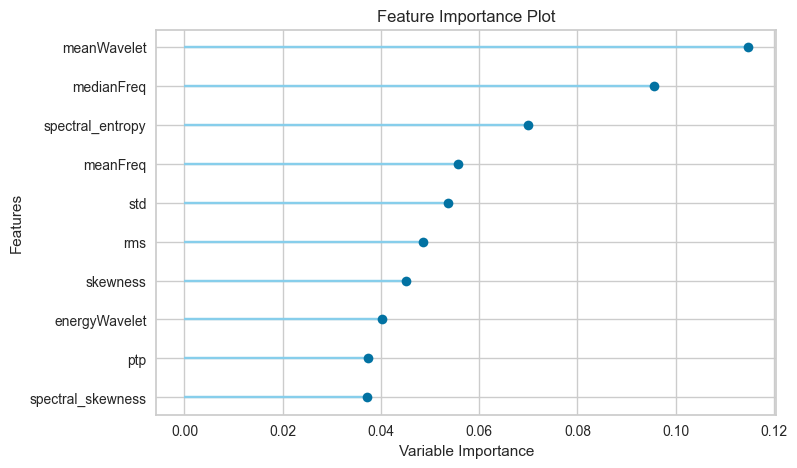

In [39]:
plot_model(rf, plot='feature')

In [40]:
predictions_rf = predict_model(rf, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Random Forest Classifier,0.9840,0.9980,0.9840,0.9841,0.9838,0.9531,0.9538,0.9672,0.0160,0.9294,0.0576


In [41]:
get_incorrect_predictions(predictions_rf)

,mean,rms,std,skewness,kurtosis,ptp,crest,impulse,clearance,shape,...,varWavelet,entropyWavelet,energyWavelet,meanSpectrogram,varSpectrogram,entropySpectrogram,energySpectrogram,Label,prediction_label,prediction_score
1466871,0.039945,-0.406328,-0.421903,0.067316,0.089498,-0.478449,0.311615,0.510597,-0.158026,1.688280,...,-0.258316,0.164643,-0.283307,-0.225574,-0.109740,-0.146105,-0.109908,healthy,damaged,0.69
1180498,0.033800,-0.373620,-0.386371,0.021888,-0.018929,-0.480323,-0.163782,-0.050395,-0.354546,0.595400,...,-0.251828,0.166304,-0.278014,-0.223109,-0.109738,-0.146089,-0.109906,healthy,damaged,0.63
1183544,0.032296,-0.378416,-0.391625,-0.116358,0.044802,-0.453951,0.125651,0.187163,-0.271088,0.714950,...,-0.252810,0.165873,-0.278760,-0.223768,-0.109735,-0.146067,-0.109903,healthy,damaged,0.65
1166343,0.032949,0.182472,0.219184,0.036628,-0.005959,0.463603,0.212457,0.319081,0.986134,1.077017,...,-0.113050,0.209697,-0.099988,-0.111224,-0.109193,-0.142459,-0.109332,healthy,damaged,0.79
1486637,0.019819,0.104295,0.133960,0.015301,-0.115156,0.229828,-0.191690,-0.228935,0.359241,-0.357563,...,-0.130764,0.189286,-0.145884,-0.135874,-0.109289,-0.143098,-0.109441,healthy,damaged,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454554,0.042124,-0.223710,-0.223013,0.011215,-0.078384,-0.250165,-0.242196,-0.242040,-0.141302,-0.220412,...,-0.226299,0.186217,-0.246998,-0.206003,-0.109721,-0.145933,-0.109887,healthy,damaged,0.62
1448457,0.043277,-0.459755,-0.480051,-0.176688,0.092109,-0.546021,0.511248,0.396472,-0.436625,0.307438,...,-0.263492,0.160212,-0.289222,-0.229276,-0.109743,-0.146133,-0.109911,healthy,damaged,0.83
1450485,0.046945,-0.256270,-0.258436,-0.084787,-0.058536,-0.234342,0.113201,0.019304,-0.066539,-0.167965,...,-0.234507,0.184384,-0.254983,-0.208876,-0.109726,-0.145974,-0.109892,healthy,damaged,0.69
1484403,0.035491,-0.383375,-0.396971,-0.028032,-0.016982,-0.472201,-0.067199,-0.059041,-0.382720,0.123877,...,-0.253688,0.166038,-0.279531,-0.223485,-0.109739,-0.146091,-0.109906,healthy,damaged,0.82


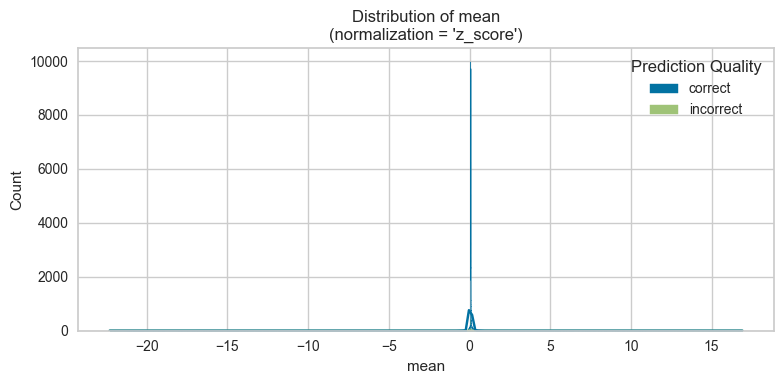

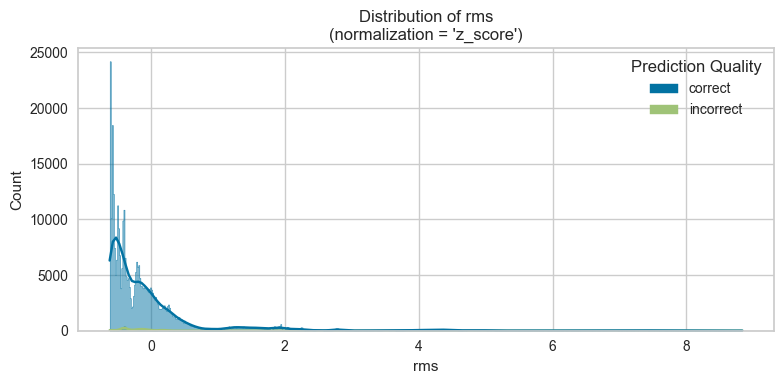

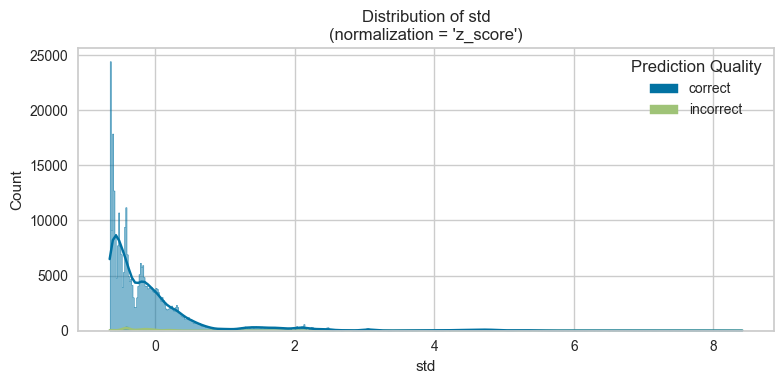

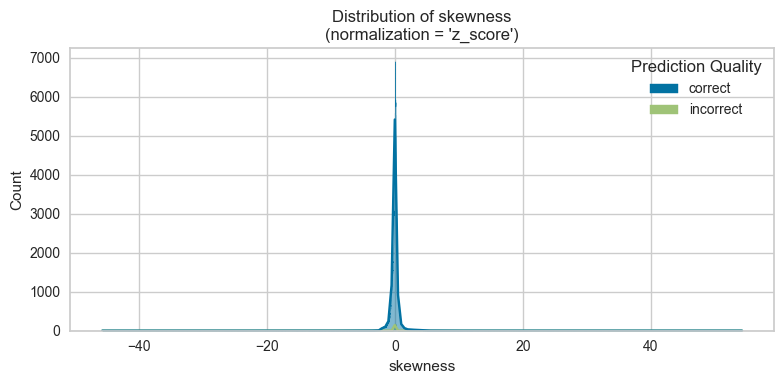

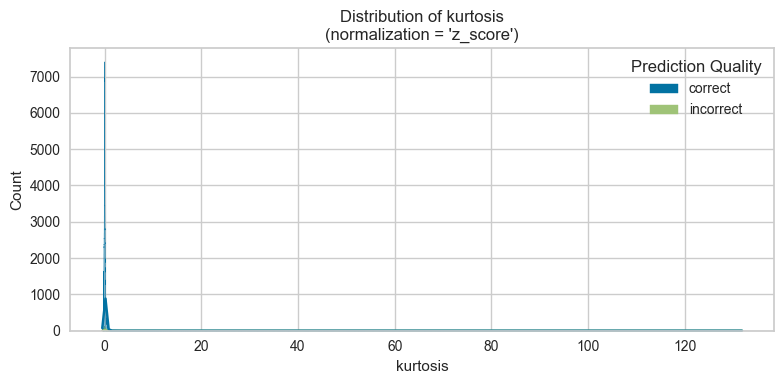

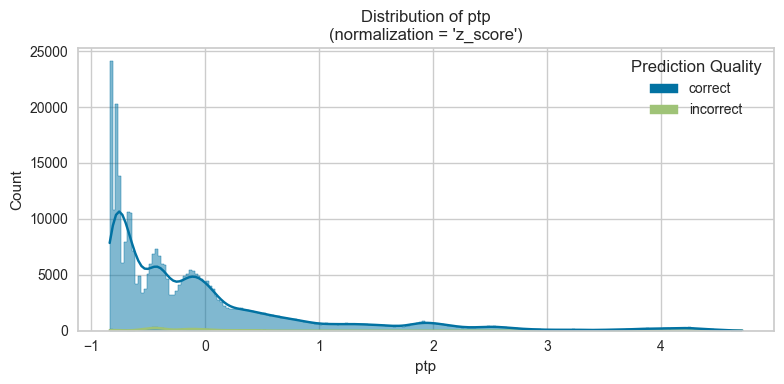

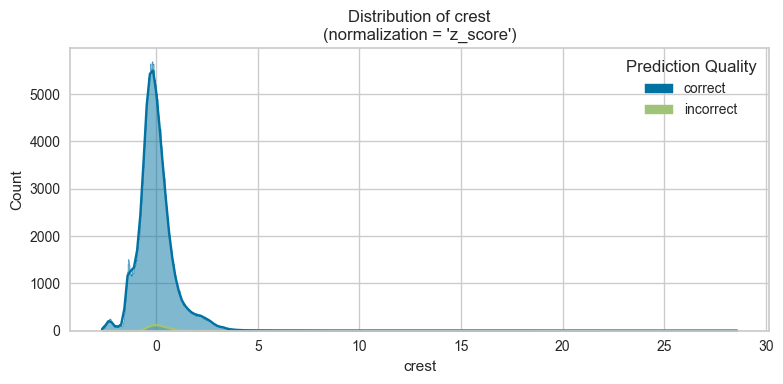

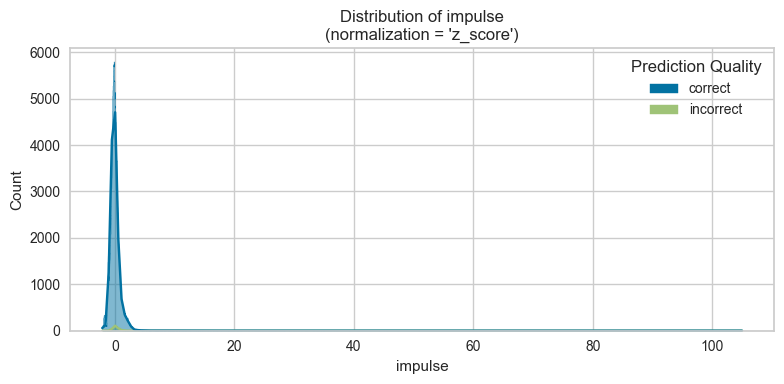

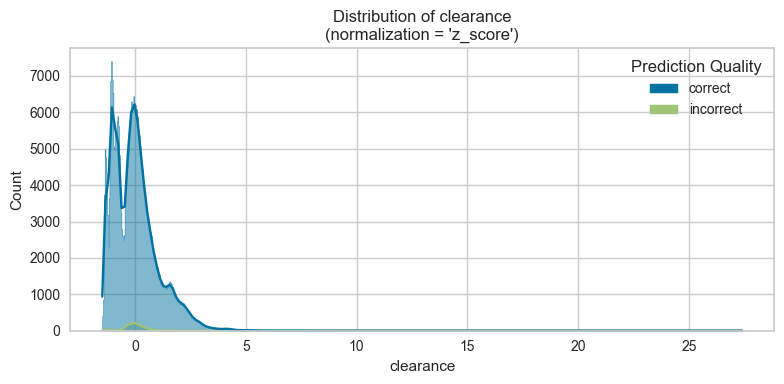

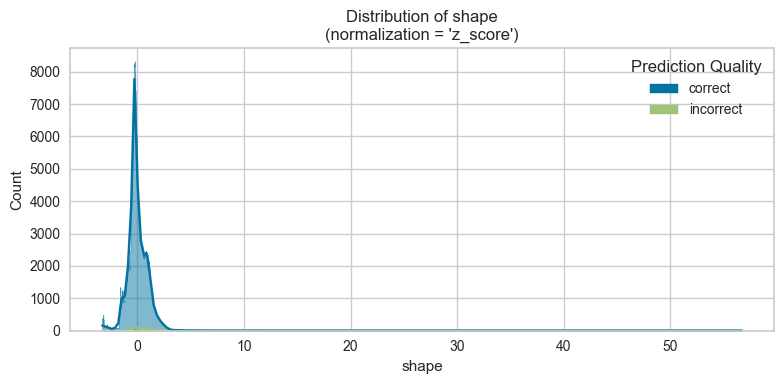

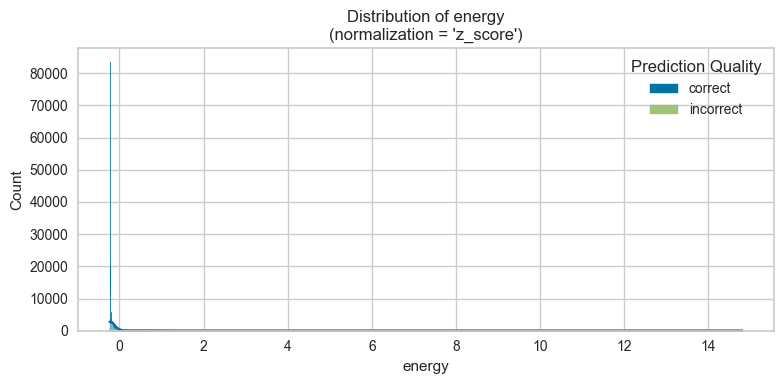

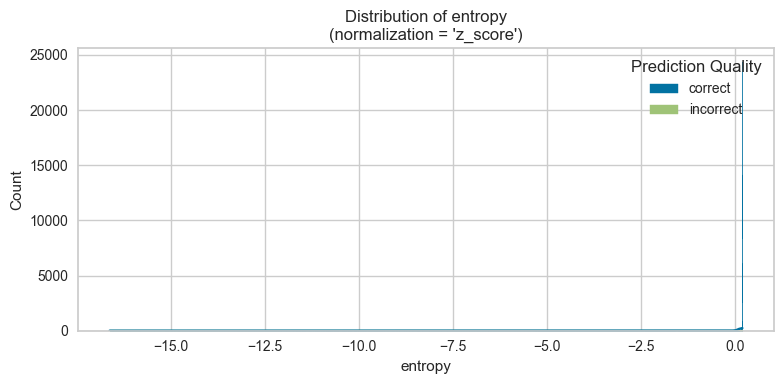

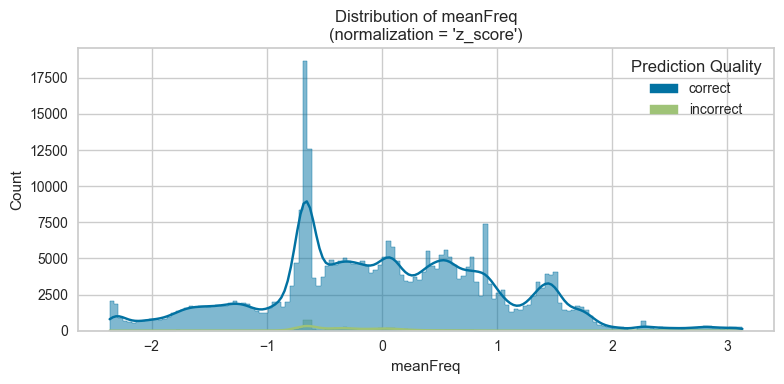

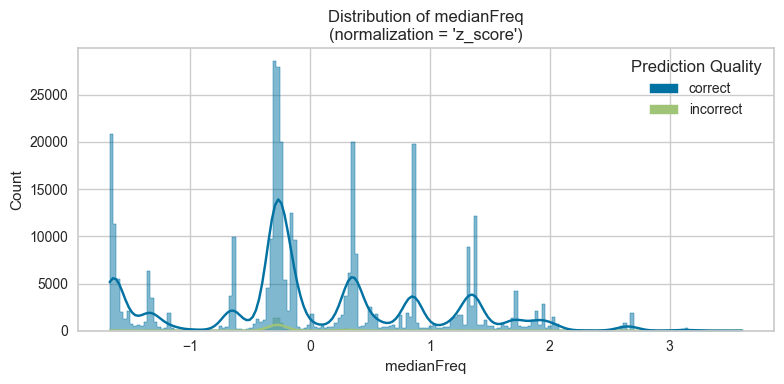

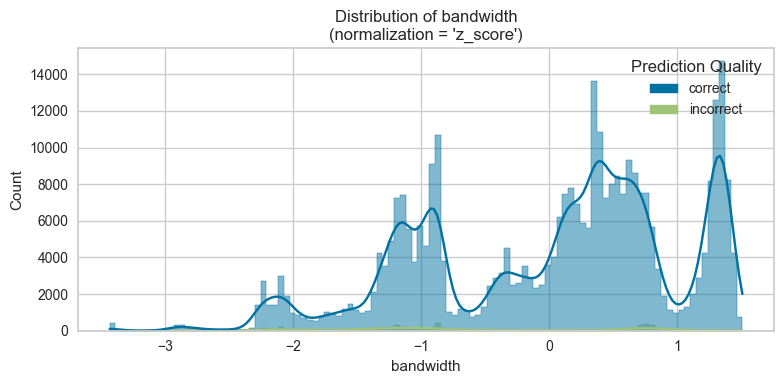

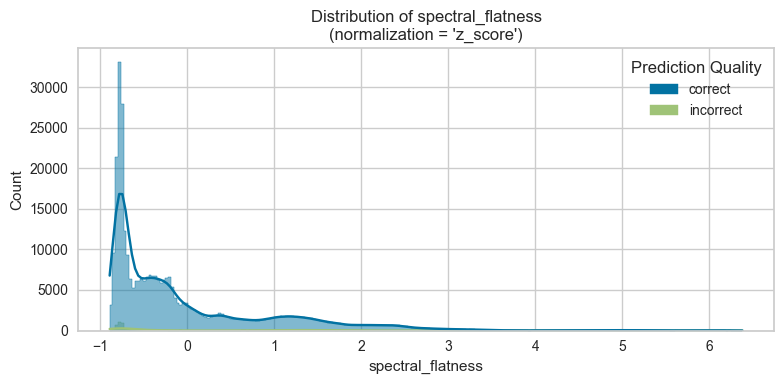

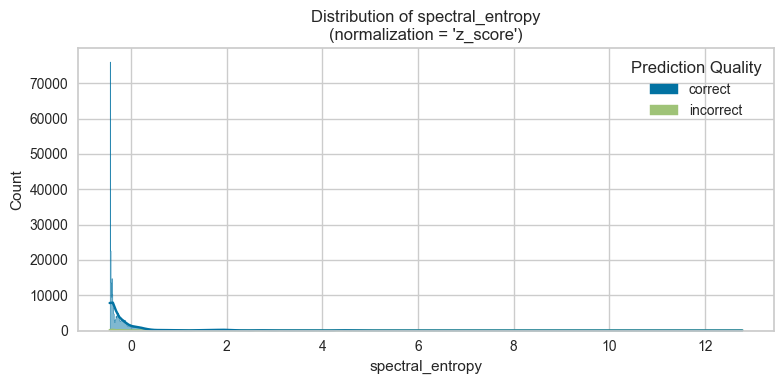

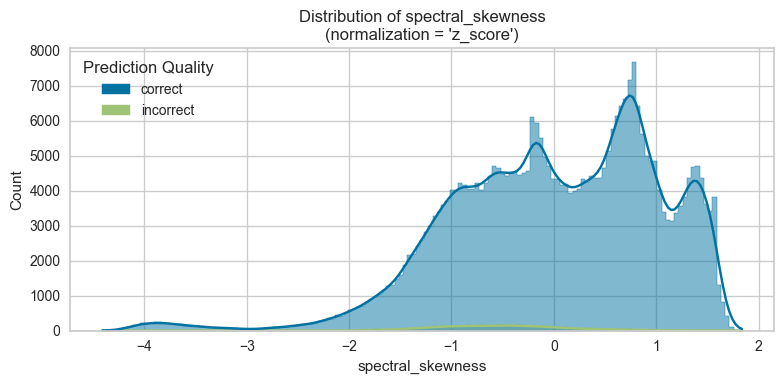

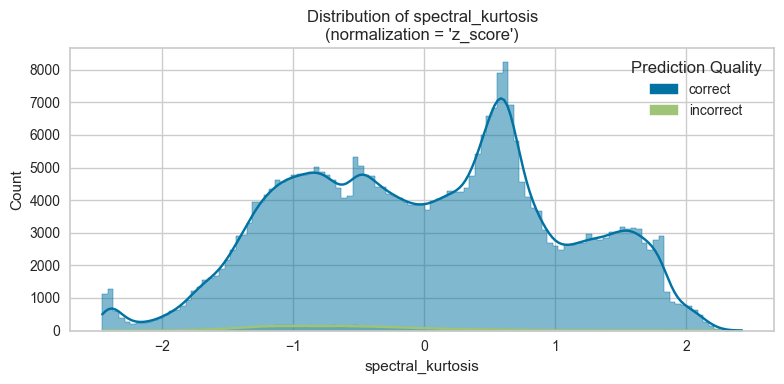

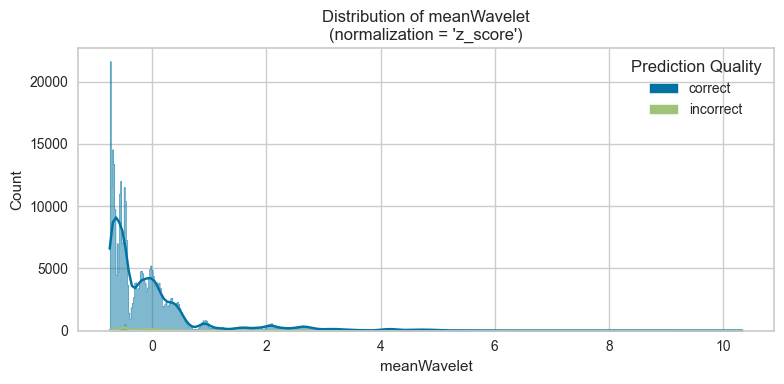

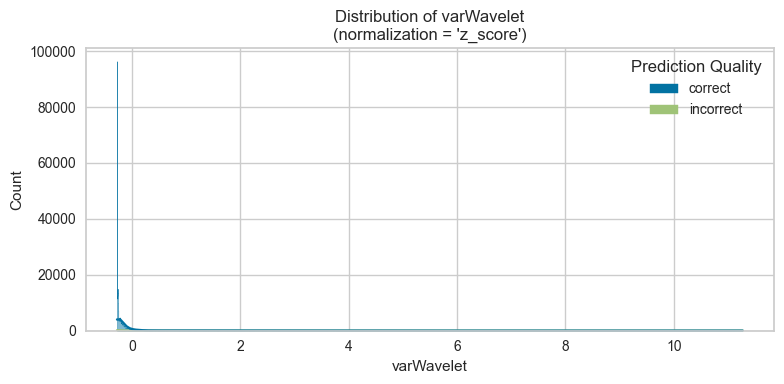

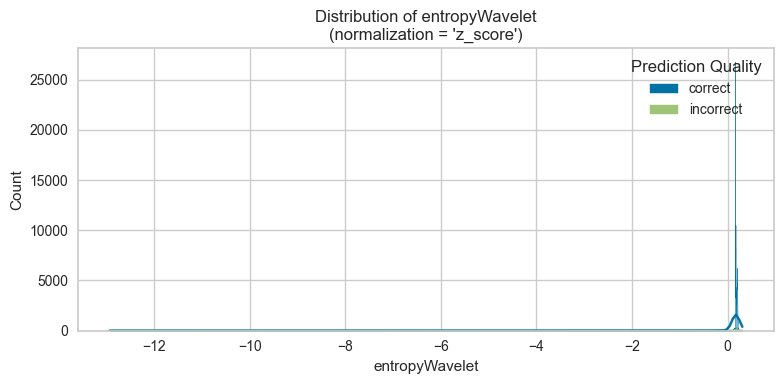

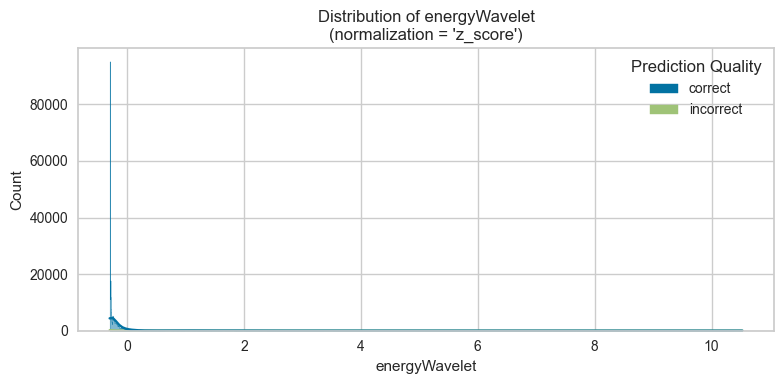

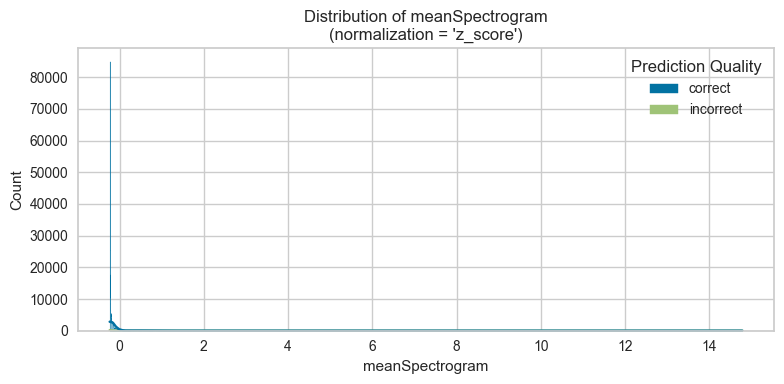

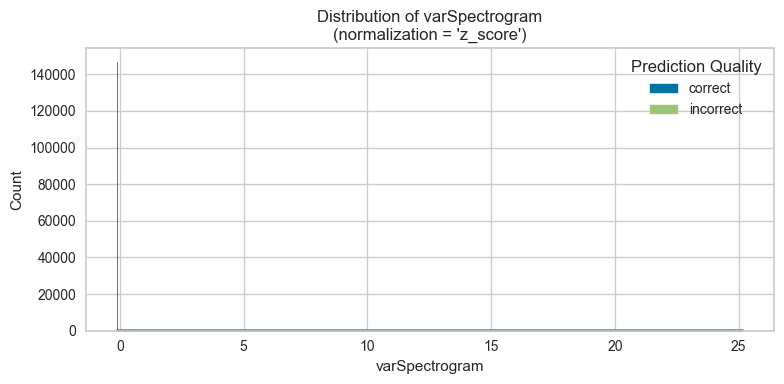

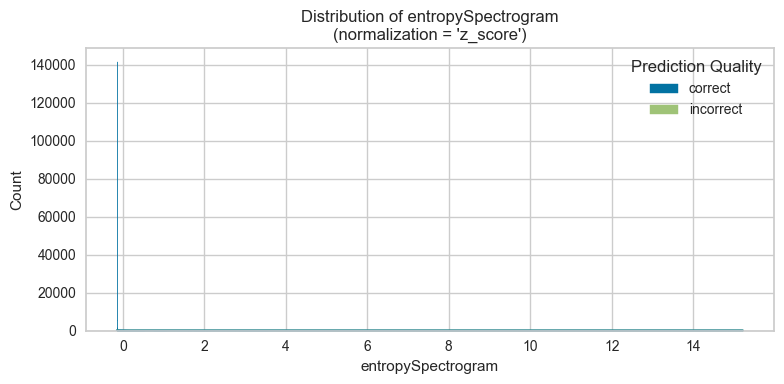

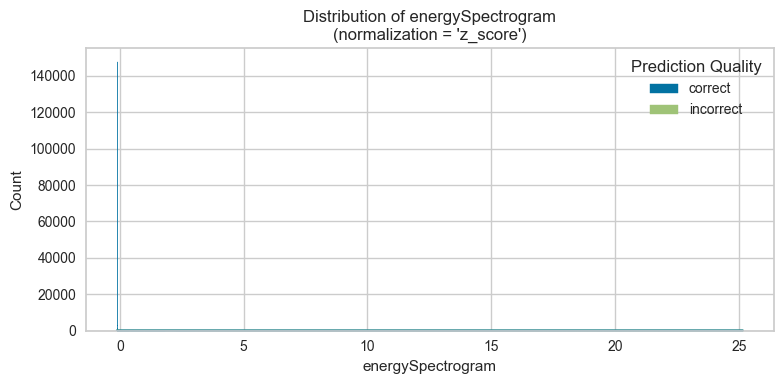

In [42]:
plotPredictionHistograms(predictions_rf, normalization_method)

## SVM

In [43]:
bestParamsSVM = {
    'alpha':1.983570694577895e-06, 
    'average':False, 
    'class_weight':None,
    'early_stopping':False, 
    'epsilon':0.1, 
    'eta0':0.050879465480455605,
    'fit_intercept':True, 
    'l1_ratio':0.3264919553269943,
    'learning_rate':'adaptive', 
    'loss':'hinge', 
    'max_iter':1000,
    'n_iter_no_change':5, 
    'n_jobs':-1, 
    'penalty':'l2', 
    'power_t':0.5,
    'random_state':1768, 
    'shuffle':True, 
    'tol':0.001,
    'validation_fraction':0.1, 
    'verbose':False, 
    'warm_start':False
}

In [44]:
svm = create_model('svm', **bestParamsSVM)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [45]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [46]:
svm_top_features = get_svm_feature_importance_df(svm, features_df_training_normalized)
svm_top_features

,Features,importance
0,entropyWavelet,87.585152
1,entropy,40.345818
2,energyWavelet,24.850798
3,energy,21.781672
4,meanSpectrogram,16.856869
5,varWavelet,16.549580
6,meanWavelet,12.772890
7,spectral_entropy,10.932343
8,rms,7.686614
9,entropySpectrogram,1.899137


In [47]:
add_top_features(svm_top_features, top_n=3)

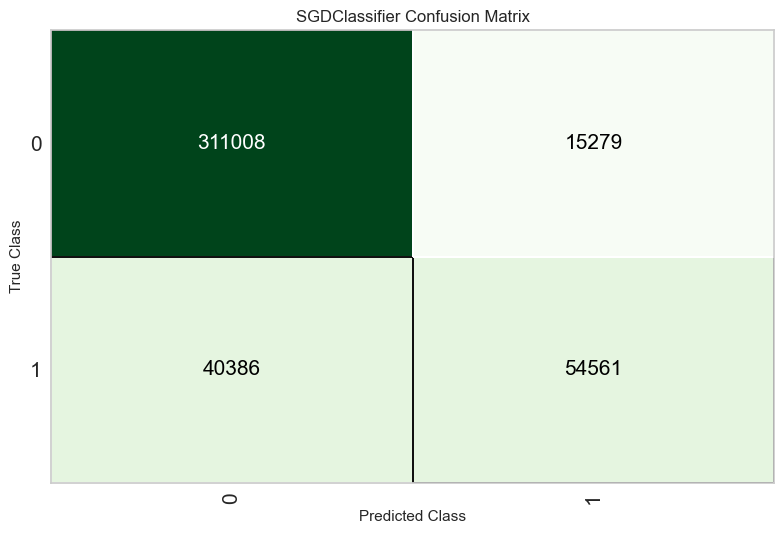

In [70]:
plot_model(svm, plot='confusion_matrix')

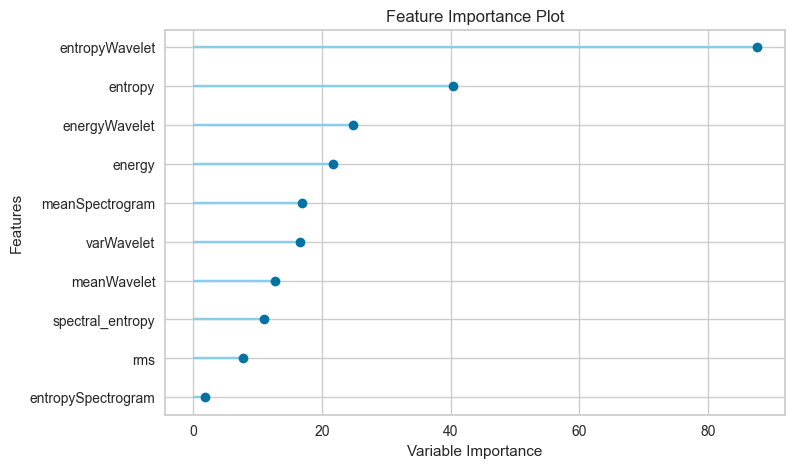

In [48]:
plot_model(svm, plot='feature')

In [49]:
predictions_svm = predict_model(svm, data=features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,SVM - Linear Kernel,0.8683,0,0.8683,0.8622,0.8604,0.5821,0.5933,0.7630,0.1317,0.4941,0


In [50]:
get_incorrect_predictions(predictions_svm)

,mean,rms,std,skewness,kurtosis,ptp,crest,impulse,clearance,shape,...,meanWavelet,varWavelet,entropyWavelet,energyWavelet,meanSpectrogram,varSpectrogram,entropySpectrogram,energySpectrogram,Label,prediction_label
269280,0.056265,-0.457678,-0.477689,0.001200,-0.149608,-0.613921,-0.297836,-0.299343,-0.655130,-0.331626,...,-0.565767,-0.263216,0.160634,-0.289041,-0.229663,-0.109744,-0.146138,-0.109912,healthy,damaged
1469143,0.041366,0.133188,0.165565,0.137116,-0.022522,0.313483,-0.166642,-0.012214,0.634406,0.837327,...,0.312264,-0.124273,0.205981,-0.121514,-0.123479,-0.109308,-0.143114,-0.109453,healthy,damaged
447873,0.060469,-0.508183,-0.532691,0.176577,-0.147759,-0.687198,-0.331018,-0.337236,-0.814208,-0.423028,...,-0.604720,-0.267979,0.156991,-0.293481,-0.231925,-0.109745,-0.146149,-0.109913,healthy,damaged
272347,0.056484,-0.455443,-0.475255,-0.201084,-0.125856,-0.622372,-0.706939,-0.571773,-0.745999,-0.222474,...,-0.560830,-0.263088,0.160768,-0.288843,-0.229676,-0.109744,-0.146137,-0.109912,healthy,damaged
1495076,0.037607,-0.399027,-0.413986,0.161695,0.072387,-0.459170,0.253071,0.253058,-0.301058,0.554098,...,-0.483171,-0.256546,0.165305,-0.281816,-0.226043,-0.109742,-0.146118,-0.109910,healthy,damaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573961,0.067054,-0.608826,-0.643563,-0.274333,-0.141100,-0.827052,-0.584588,-0.551828,-1.329256,-0.675409,...,-0.734410,-0.271502,0.151762,-0.297331,-0.233961,-0.109746,-0.146153,-0.109913,damaged,healthy
45617,0.063423,-0.465484,-0.486221,0.026500,-0.321563,-0.689178,-1.443931,-1.250087,-0.995918,-1.667803,...,-0.582847,-0.263824,0.160276,-0.289833,-0.230063,-0.109744,-0.146141,-0.109912,healthy,damaged
111017,0.070819,-0.492701,-0.515986,-0.401682,-0.085553,-0.659369,-0.365942,-0.206853,-0.696848,0.560043,...,-0.577959,-0.267314,0.158217,-0.292515,-0.231246,-0.109745,-0.146149,-0.109913,healthy,damaged
1479823,0.036596,-0.390552,-0.404771,0.031997,0.005838,-0.459098,0.249848,0.192342,-0.295604,0.240234,...,-0.480481,-0.255094,0.165961,-0.280589,-0.223930,-0.109737,-0.146084,-0.109905,healthy,damaged


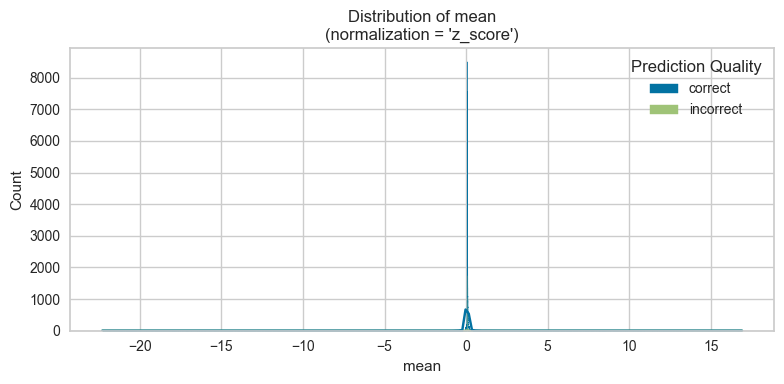

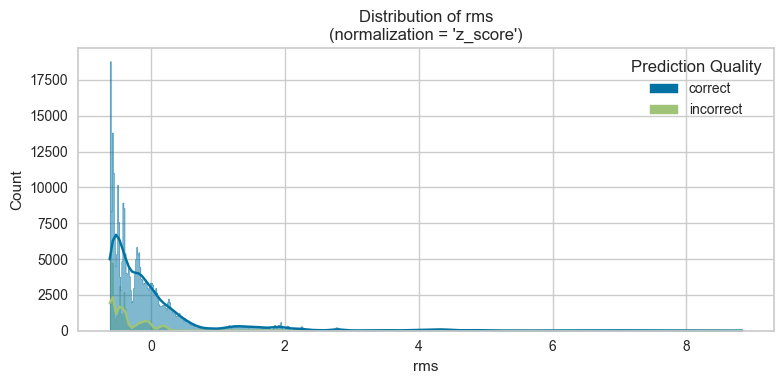

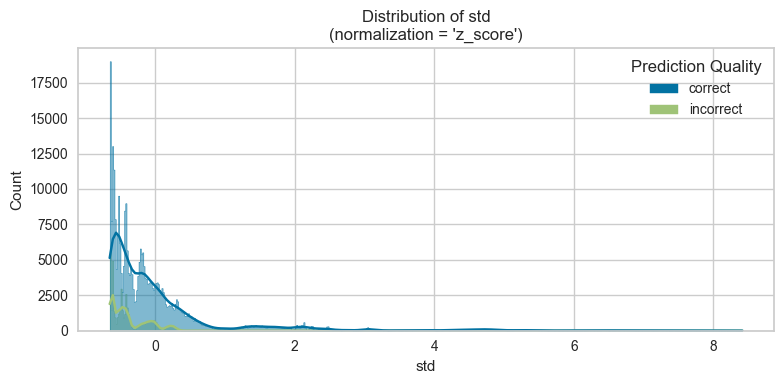

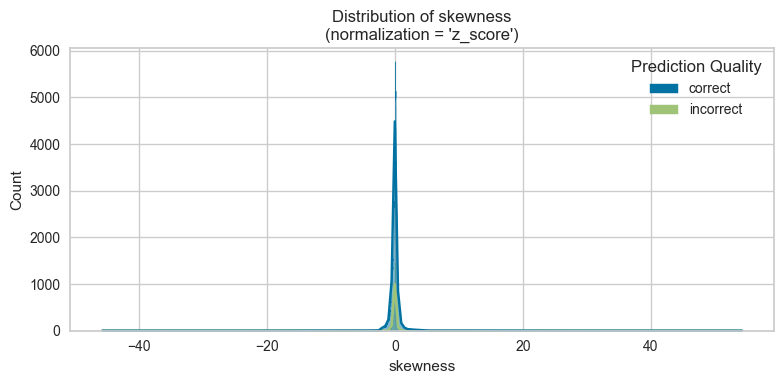

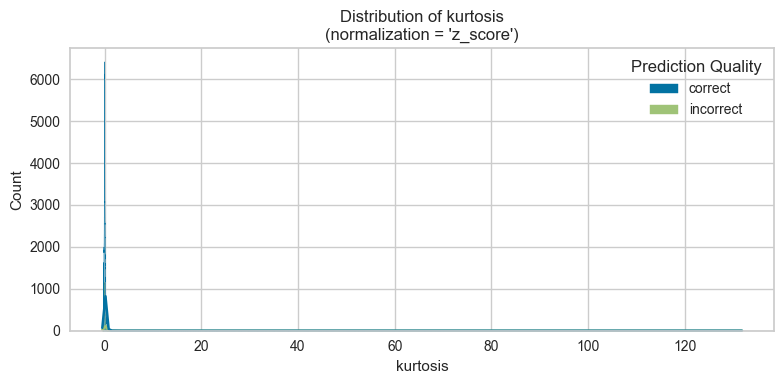

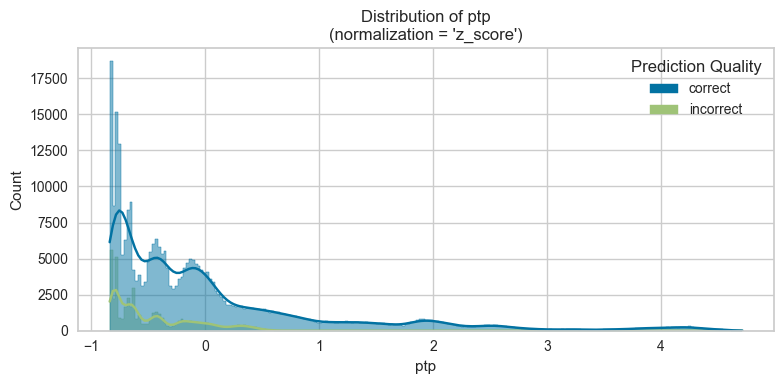

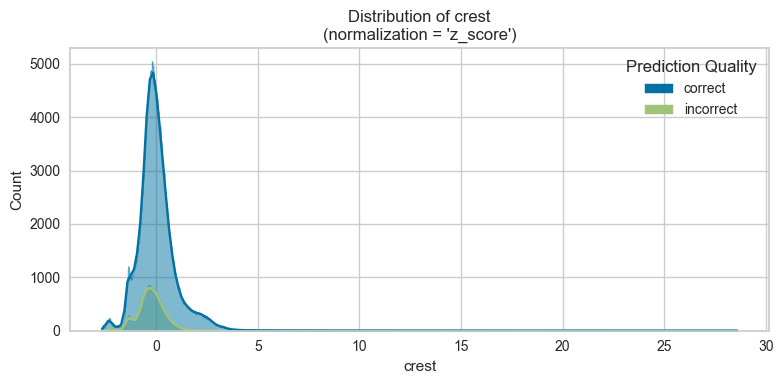

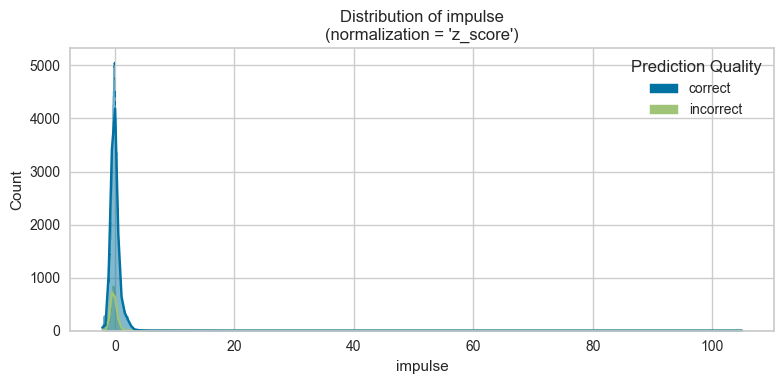

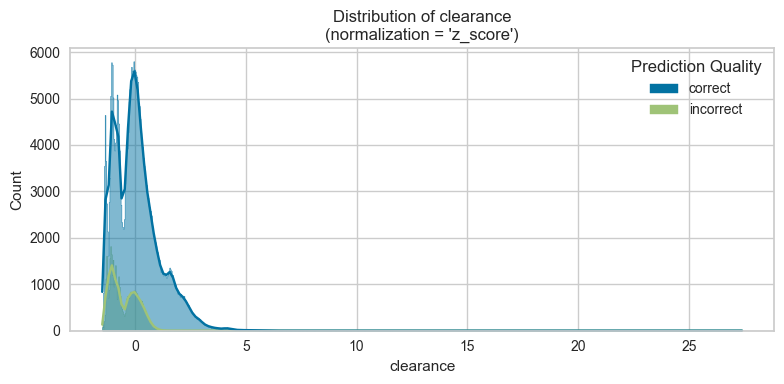

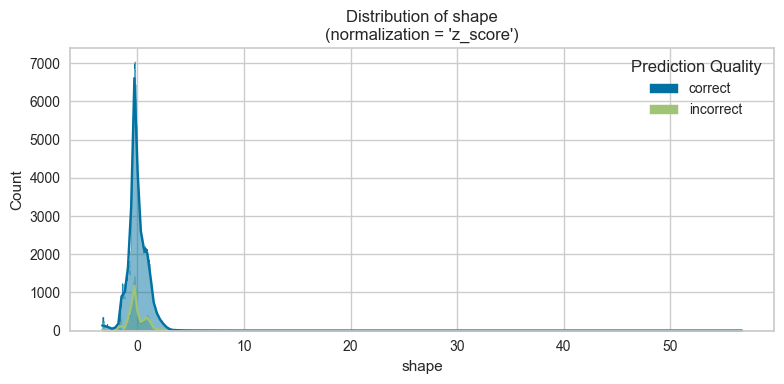

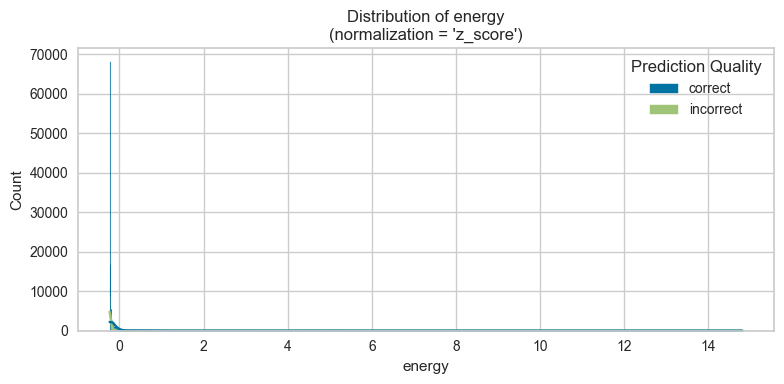

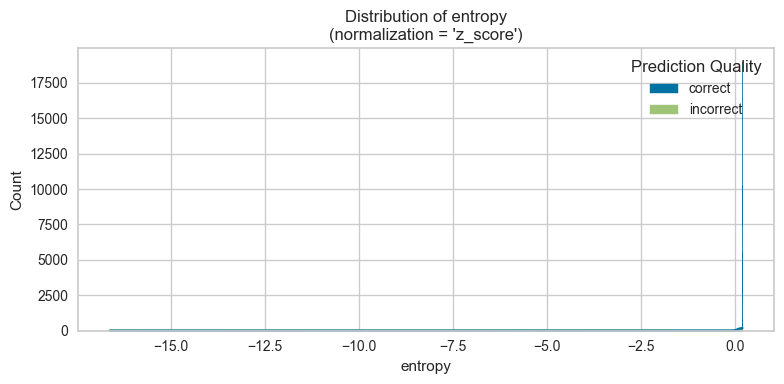

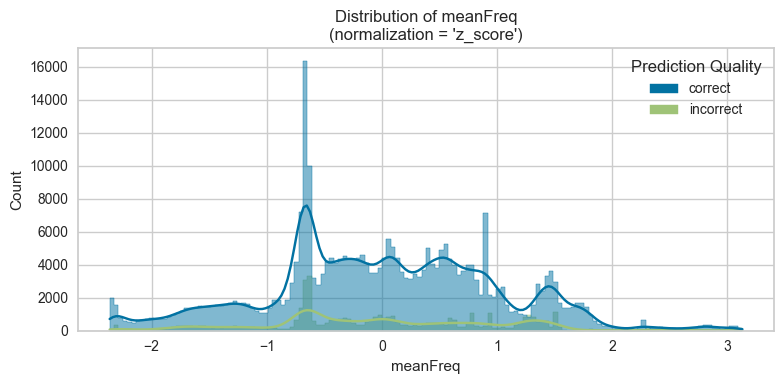

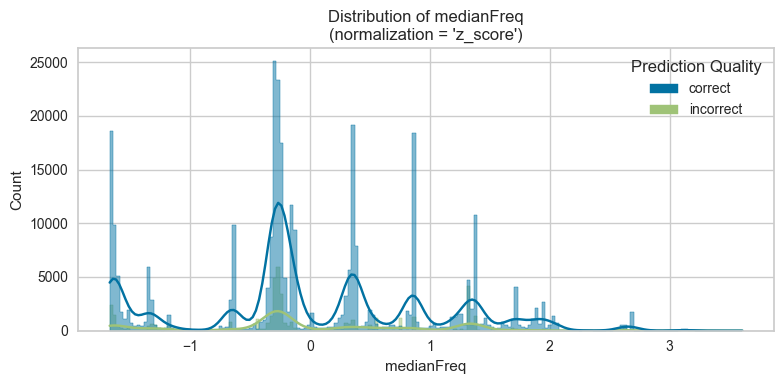

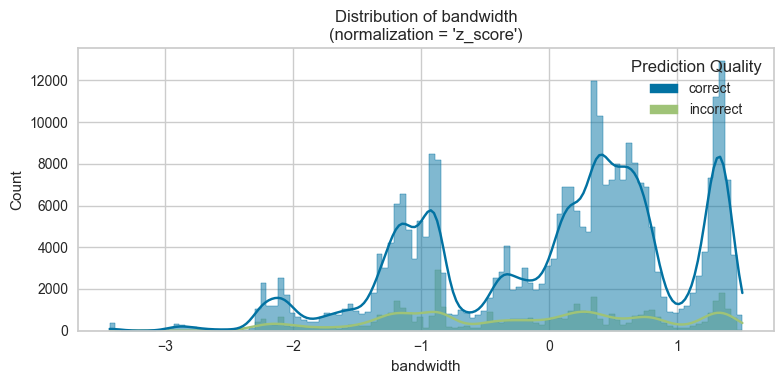

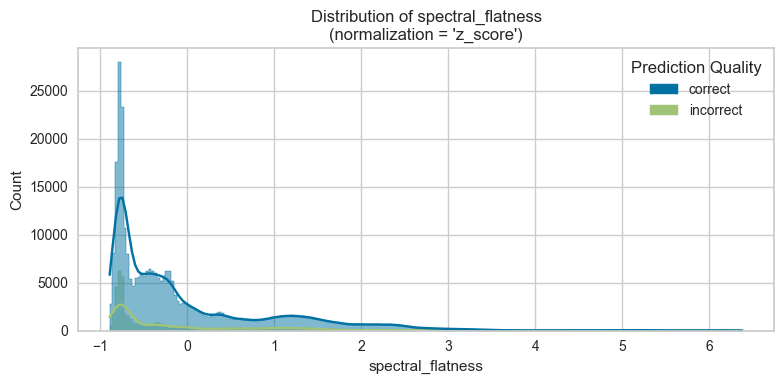

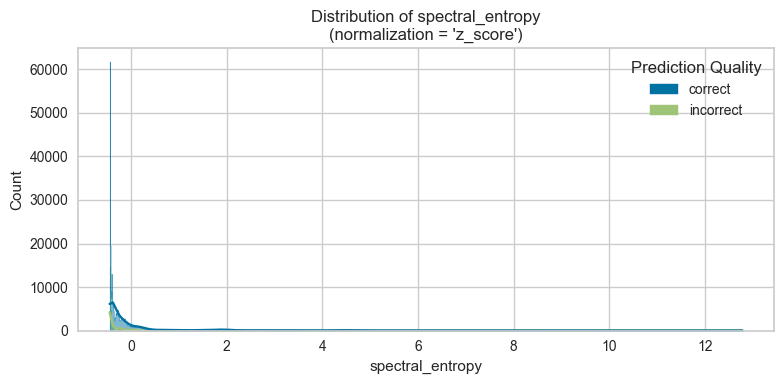

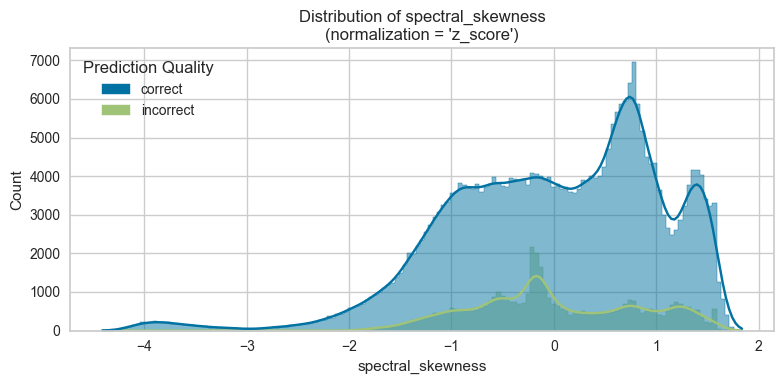

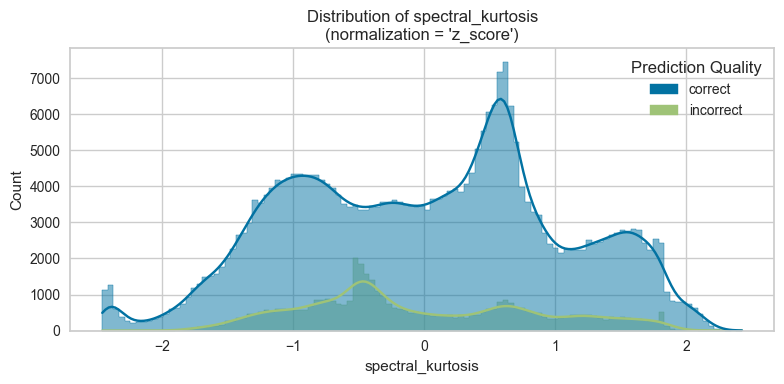

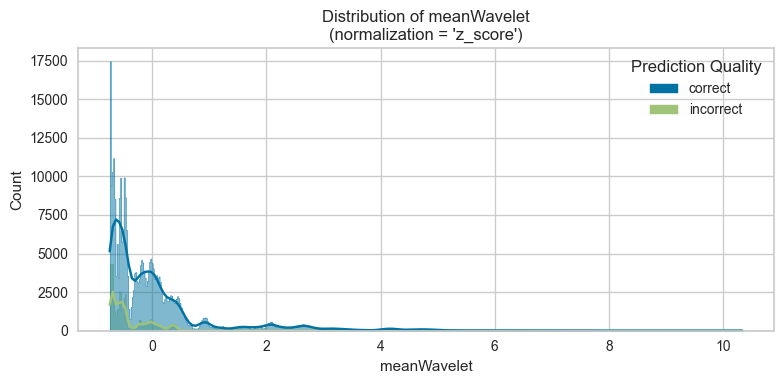

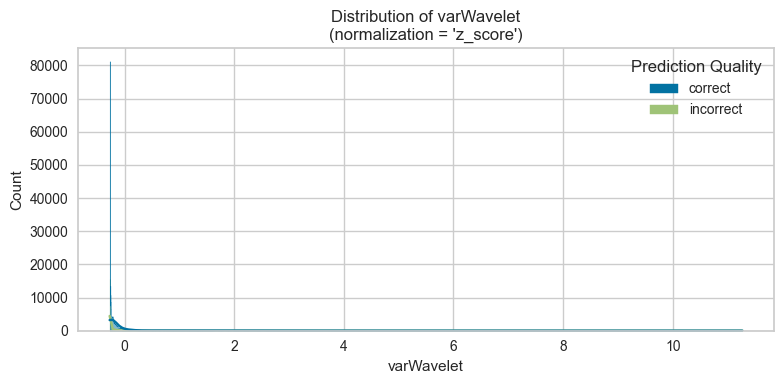

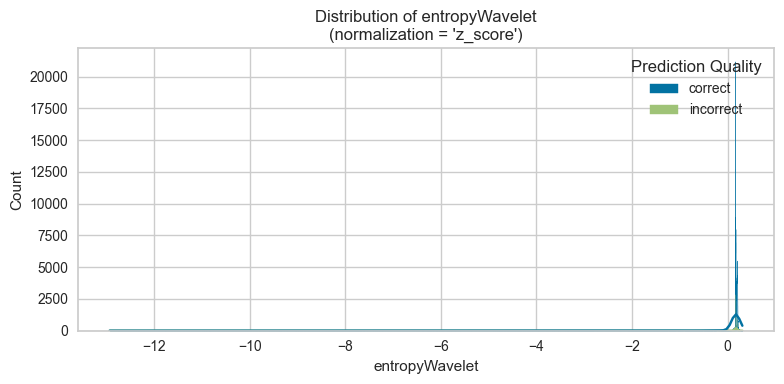

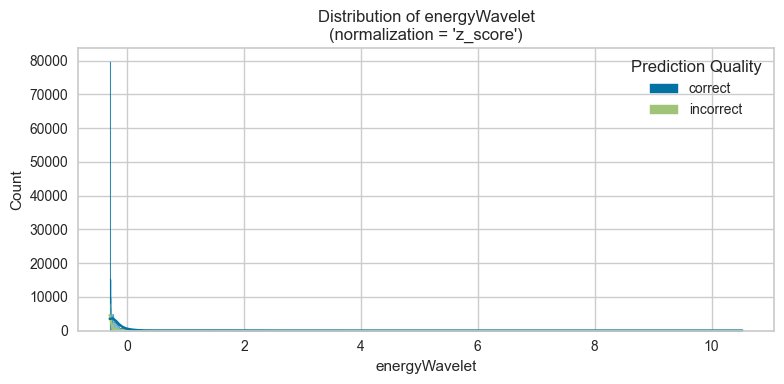

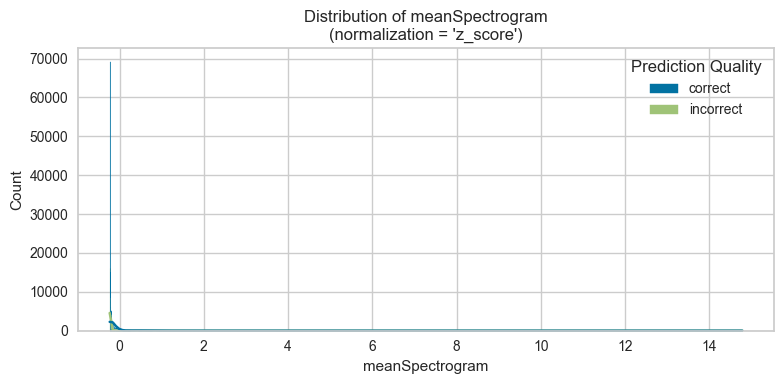

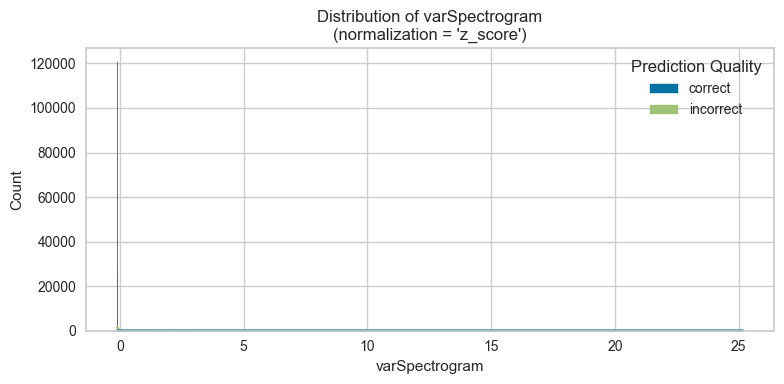

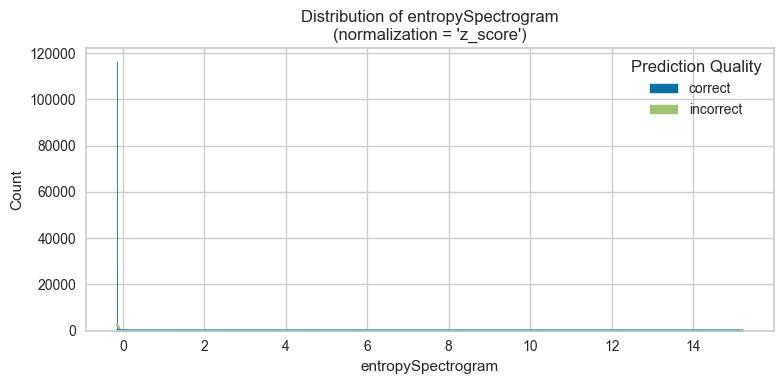

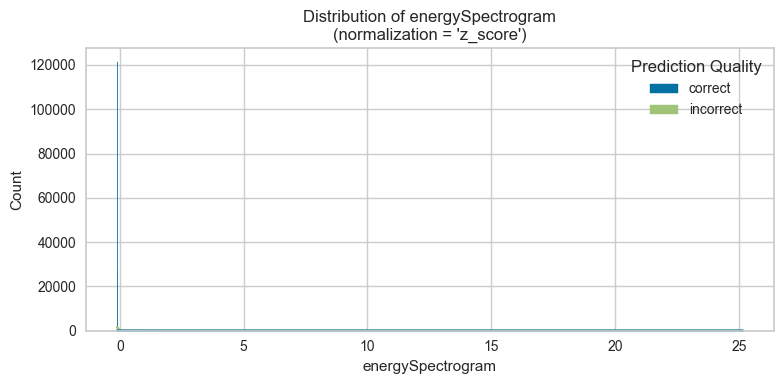

In [51]:
plotPredictionHistograms(predictions_svm, normalization_method)

# Experiment Setup (DL)

## Configure Data

In [52]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (1123288, 28) | Val Shape: (280823, 28) | Test Shape: (351028, 28)


In [53]:
target = "Label"
num_labels = normalized_df['Label'].nunique()

categorical_cols = [
    col
    for col in features_df_training_normalized.select_dtypes(include=["object","category"]).columns
    if col != target
]

continuous_cols = features_df_training_normalized.select_dtypes(include=["number"]).columns.tolist()

In [54]:
print("Target:", target)
print("Categorical inputs:", categorical_cols)  
print("Continuous inputs:", continuous_cols)    

Target: Label
Categorical inputs: []
Continuous inputs: ['mean', 'rms', 'std', 'skewness', 'kurtosis', 'ptp', 'crest', 'impulse', 'clearance', 'shape', 'energy', 'entropy', 'meanFreq', 'medianFreq', 'bandwidth', 'spectral_flatness', 'spectral_entropy', 'spectral_skewness', 'spectral_kurtosis', 'meanWavelet', 'varWavelet', 'entropyWavelet', 'energyWavelet', 'meanSpectrogram', 'varSpectrogram', 'entropySpectrogram', 'energySpectrogram']


In [55]:
data_config = DataConfig(
    target=[target],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
)

In [56]:
available_gpu=1 if torch.cuda.is_available() else 0
print(f"Available GPU: {'Yes' if available_gpu else 'No'}")

Available GPU: Yes


In [57]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    batch_size=256,
)

optimizer_config = OptimizerConfig()

experiment_config = ExperimentConfig(
        project_name=experiment_name,
        run_name=f"{experiment_name}_run",
        log_target="tensorboard",
    )

In [58]:
tabnet_config = TabNetModelConfig(
        task="classification",
        n_d=33,
        n_a=46,
        n_steps=3,
        gamma=1.2864230491528987,
        embedding_dropout=0.1825276618254278,
        learning_rate=0.00468046516266798,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [59]:
tabnet_model = TabularModel(
        data_config=data_config,
        model_config=tabnet_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=True
    )

2025-10-06 16:59:45,937 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [60]:
tabnet_model.fit(train=train, validation=val)

Seed set to 42


2025-10-06 16:59:46,005 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-06 16:59:46,165 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-06 16:59:47,199 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabNetModel

2025-10-06 16:59:47,340 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-06 16:59:47,402 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone   │  125 K │ train │
│ 2 │ _head            │ Identity         │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 125 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 125 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 107                                                                                         
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-06 18:02:57,501 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-06 18:02:57,501 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [61]:
tabnet_pred_df = tabnet_model.predict(test)
tabnet_pred_df.head(10)
tabnet_result = tabnet_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9423123002052307     │
│        test_auroc         │    0.9773964881896973     │
│     test_cohen_kappa      │    0.8179362416267395     │
│       test_f1_score       │    0.9423123002052307     │
│   test_hamming_distance   │   0.057687707245349884    │
│    test_jaccard_index     │    0.8380526304244995     │
│         test_loss         │    0.1390267312526703     │
│        test_loss_0        │    0.1390267312526703     │
│  test_matthews_corrcoef   │    0.8309669494628906     │
│      test_precision       │    0.9423123002052307     │
│        test_recall        │    0.9423123002052307     │
└───────────────────────────┴───────────────────────────┘

## GANDALF

In [62]:
gandalf_config = GANDALFConfig(
        task="classification",
        gflu_stages=8,
        gflu_dropout=0.20621973444441227,
        gflu_feature_init_sparsity=0.5069371167197942,
        learnable_sparsity=False,
        embedding_dropout= 0.06647823724375934,
        batch_norm_continuous_input=False,
        learning_rate=2.6124262014312122e-05,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [63]:
gandalf_model = TabularModel(
    data_config=data_config,
    model_config=gandalf_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2025-10-06 18:04:32,563 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [64]:
gandalf_model.fit(train=train, validation=val)

Seed set to 42


2025-10-06 18:04:32,610 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-06 18:04:32,918 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-06 18:04:34,012 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-10-06 18:04:34,137 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-06 18:04:34,184 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │ 35.9 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │      0 │ train │
│ 2 │ _head            │ Sequential       │     58 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 35.9 K                                                                                           
Non-trainable params: 8                                                                                            
Total params: 35.9 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 30                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-06 18:58:20,168 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-06 18:58:20,168 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [65]:
gandalf_pred_df = gandalf_model.predict(test)
gandalf_pred_df.head(10)

,Label_damaged_probability,Label_healthy_probability,Label_prediction
1575777,0.902884,0.097116,damaged
269280,0.150951,0.849049,healthy
891733,0.974361,0.025638,damaged
210511,0.765531,0.234469,damaged
845522,0.998618,0.001382,damaged
1082755,0.985132,0.014868,damaged
1715124,0.806675,0.193325,damaged
1059125,0.952785,0.047215,damaged
1281366,0.853552,0.146448,damaged
1347639,0.858801,0.141199,damaged


In [66]:
gandalf_result = gandalf_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9033268094062805     │
│        test_auroc         │    0.9192304611206055     │
│     test_cohen_kappa      │    0.6868761777877808     │
│       test_f1_score       │    0.9033268094062805     │
│   test_hamming_distance   │    0.09667319804430008    │
│    test_jaccard_index     │     0.741062581539154     │
│         test_loss         │    0.2636224329471588     │
│        test_loss_0        │    0.2636224329471588     │
│  test_matthews_corrcoef   │    0.7058851718902588     │
│      test_precision       │    0.9033268094062805     │
│        test_recall        │    0.9033268094062805     │
└───────────────────────────┴───────────────────────────┘

In [67]:
gandalf_top_features = gandalf_model.feature_importance().sort_values("importance", ascending=False)
gandalf_top_features

,Features,importance
14,bandwidth,0.797033
17,spectral_skewness,0.625830
5,ptp,0.452553
12,meanFreq,0.397337
21,entropyWavelet,0.353994
18,spectral_kurtosis,0.351573
8,clearance,0.331234
13,medianFreq,0.323353
9,shape,0.299027
6,crest,0.296782


In [68]:
add_top_features(gandalf_top_features, top_n=3)

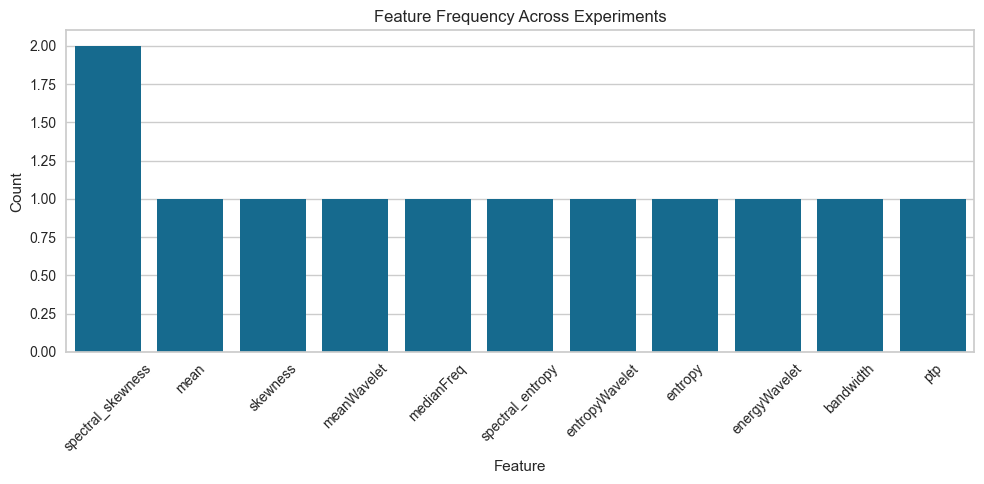

In [69]:
plot_feature_importance()